In [18]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys


In [3]:
run_name = 'run0'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from C:\Users\Emma\Desktop\analysis\2021\02\14\run0\run0-datamodel.p


In [4]:
tweezer_freq_list = [108,110,112,114,116]
num_tweezers = len(tweezer_freq_list)
# cav_odt_att_list = [0]
mol_freq_list = [4.5,5,5.5,6,6.5,7,7.5,8]
pzt_para_list = [5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
probe_att_list = [0.1,1,2,3]
num_points = len(pzt_para_list) * len(probe_att_list)
print(num_points)

t_exposure = 500

t_hold_1 = 100
t_hold_2 = 1000
t_hold_3 = 10000
t_frame_1 = t_exposure + t_hold_1
t_frame_2 = t_exposure + t_hold_2
t_frame_3 = t_exposure + t_hold_3

# def roi_center(tweezer_freq, pzt_ortho, pzt_para):
#     center_x = round(1.4167*(tweezer_freq-108) + 9 + 0.3*(pzt_ortho+5) + 1.2*pzt_para)
#     center_y = round(27.7*(tweezer_freq-108) + 79  + 1.2*(pzt_ortho+5) + 0.2*pzt_para)
#     return [center_x, center_y]

# def roi_slice_func(tweezer_freq, pzt_ortho, pzt_para):
#     center_x = roi_center(tweezer_freq, pzt_ortho, pzt_para)[0]
#     center_y = roi_center(tweezer_freq, pzt_ortho, pzt_para)[1]
#     return tuple((slice(round(center_y - roi_height/2), round(center_y + roi_height/2), 1), \
#                   slice(round(center_x - roi_width/2), round(center_x + roi_width/2), 1)))

roi_width = 14
roi_height = 12
roi_area = roi_width * roi_width
#must be even number


def roi_center(tweezer_freq, pzt_ortho, pzt_para):
    center_x = (1.3867*(tweezer_freq-108) + 16 + 0.3*(pzt_ortho+5) + 1.4*(pzt_para-5))
    center_y = (27.8*(tweezer_freq-108) + 75 + 1.2*(pzt_ortho+5) + 0.3*(pzt_para-5))
    return [center_x, center_y]
def roi_slice_func(tweezer_freq, pzt_ortho, pzt_para):
    center_x = roi_center(tweezer_freq, pzt_ortho, pzt_para)[0]
    center_y = roi_center(tweezer_freq, pzt_ortho, pzt_para)[1]
    return tuple((slice(round(center_y - roi_height/2), round(center_y + roi_height/2), 1), \
                  slice(round(center_x - roi_width/2), round(center_x + roi_width/2), 1)))

40


In [5]:
tweezer_freq_list = [108,110,112,114,116]
num_tweezers = len(tweezer_freq_list)

probe_att_list = [0.1,1,2,3]
pzt_para_list = [5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]

num_points = datamodel.num_points #len(pzt_para_list) * len(probe_att_list)

tweezer_freq_list = [108,110,112,114,116]
num_tweezers = 5 #len(tweezer_freq_list)

mol_freq_list = [4.5,5,5.5,6,6.5,7,7.5,8]
num_frames = 10 #len(mol_freq_list) + 2

num_shots = datamodel.num_shots

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')


t_exposure = 500

t_hold_1 = 100
t_hold_2 = 1000
t_hold_3 = 10000
t_frame_1 = t_exposure + t_hold_1
t_frame_2 = t_exposure + t_hold_2
t_frame_3 = t_exposure + t_hold_3

roi_width = 14
roi_height = 12
roi_area = roi_width * roi_width

40 points
10 frames
5 tweezers
5456 shots


In [6]:
# build counts_dict directly: 

counts_dict = dict()
for point in range(num_points):
    if point not in counts_dict:
        counts_dict[point] = dict()
    for frame_num in range(num_frames):
        if frame_num not in counts_dict[point]:
            counts_dict[point][frame_num]=dict()
        for twz_counter in range(len(tweezer_freq_list)):
            if twz_counter not in counts_dict[point][frame_num]:
                counts_dict[point][frame_num][twz_counter]=[]   
            counts_dict[point][frame_num][twz_counter] =\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point)

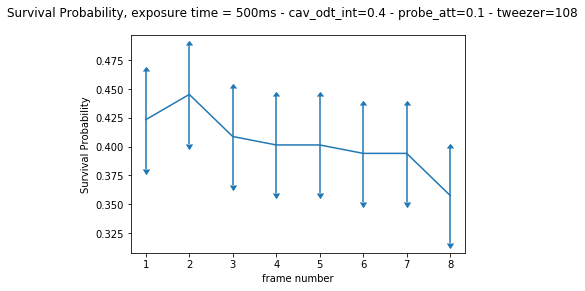

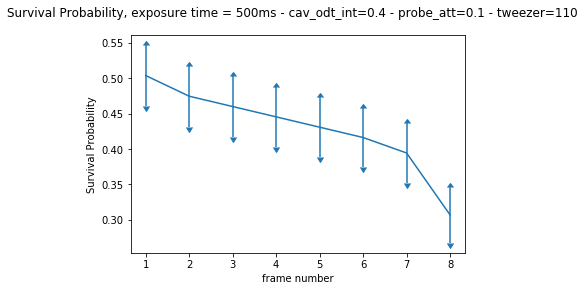

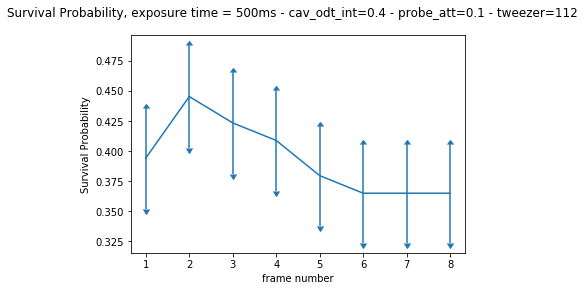

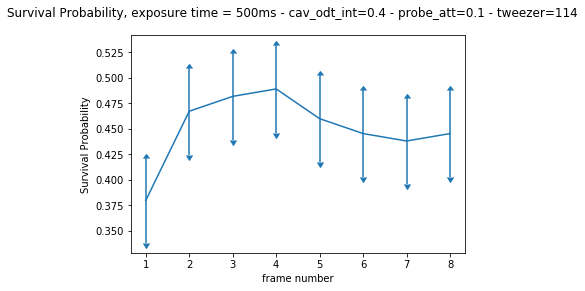

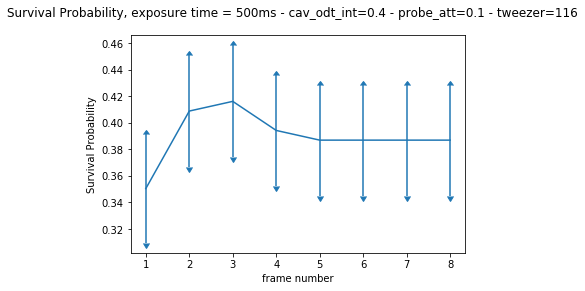

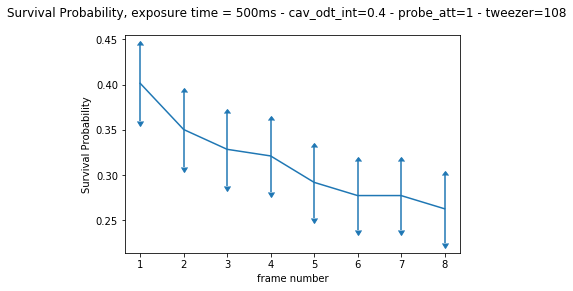

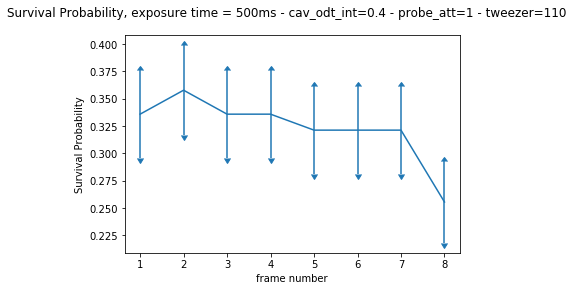

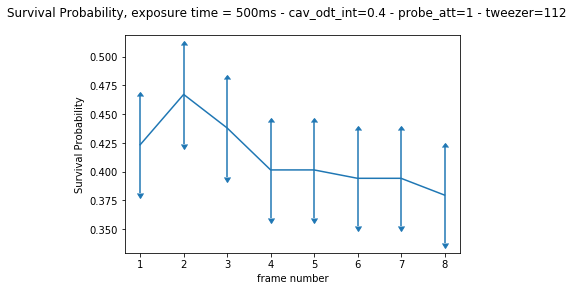

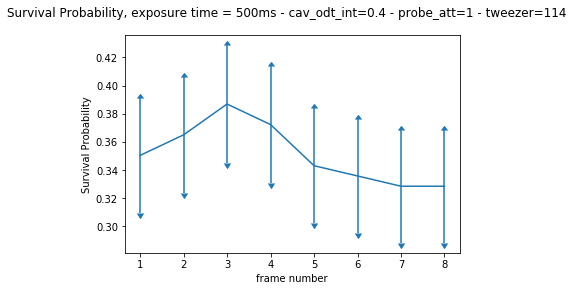

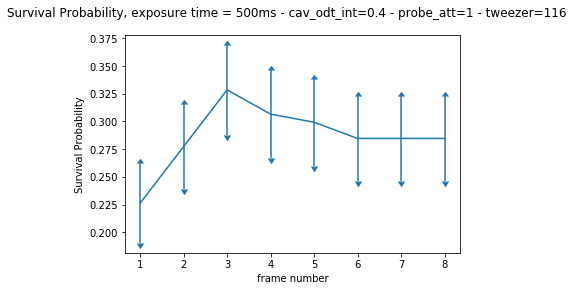

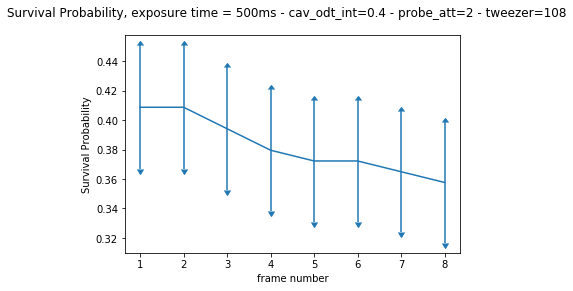

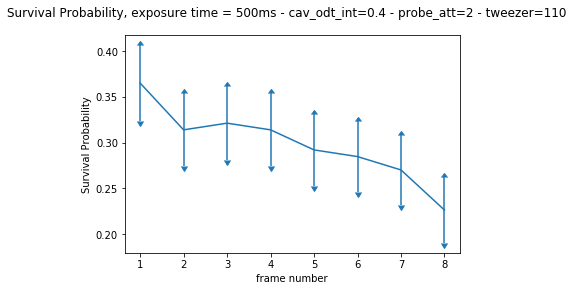

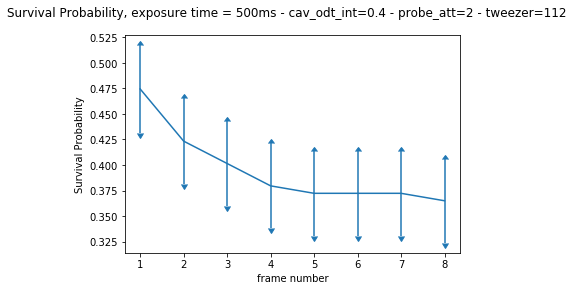

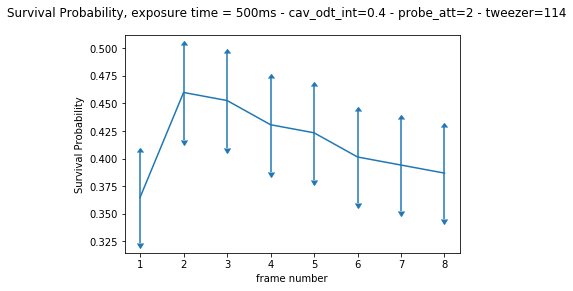

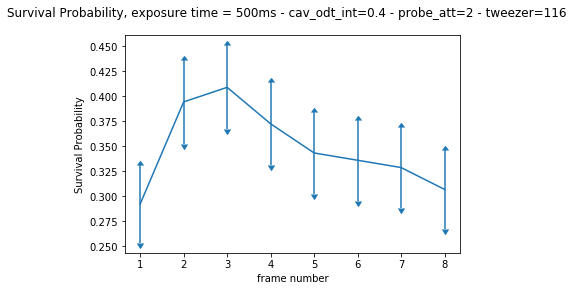

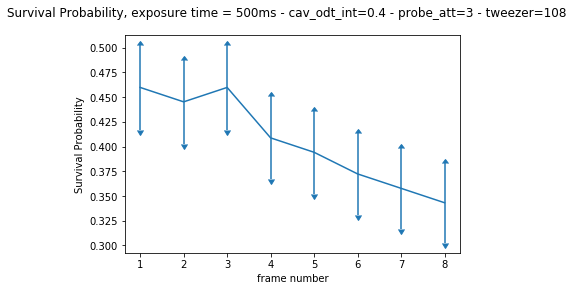

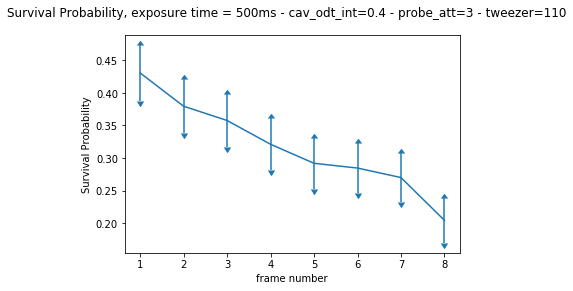

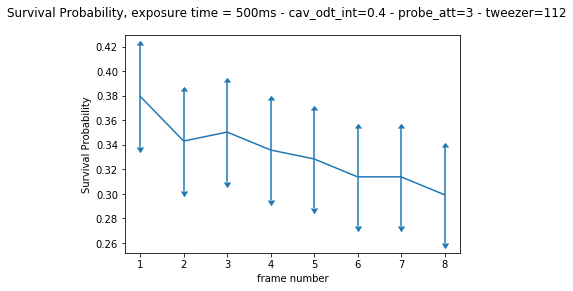

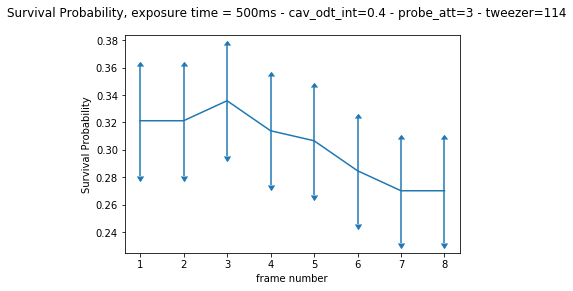

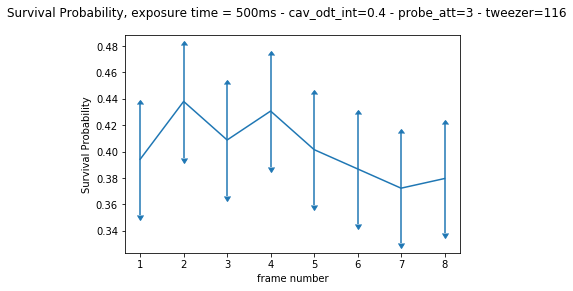

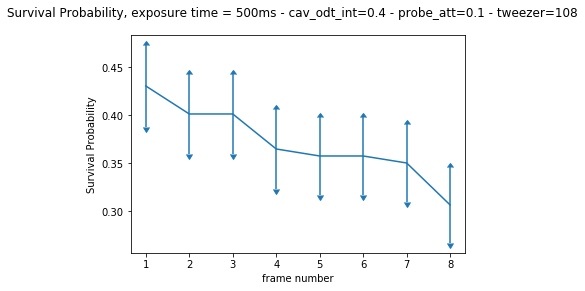

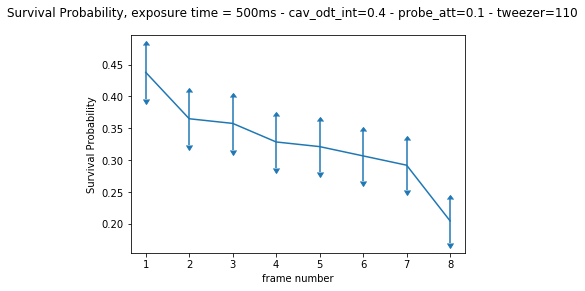

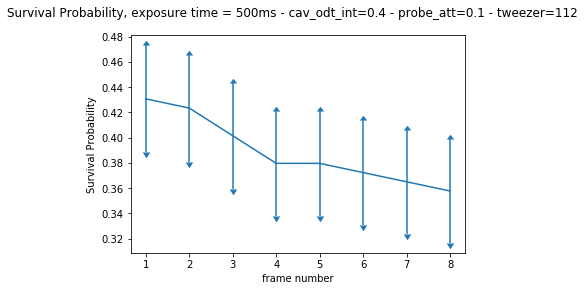

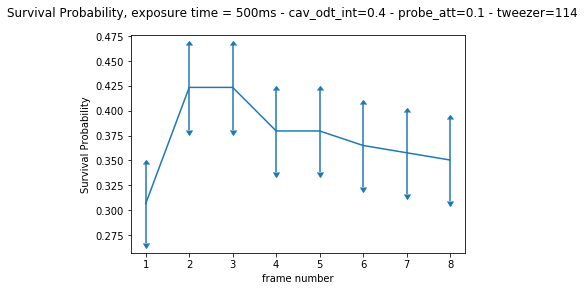

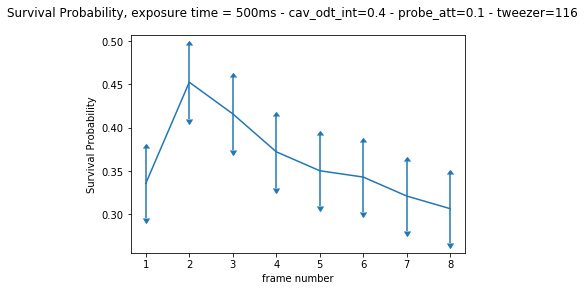

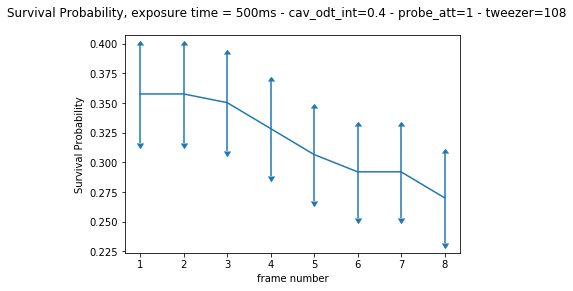

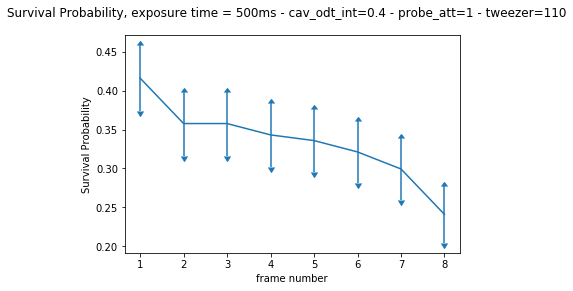

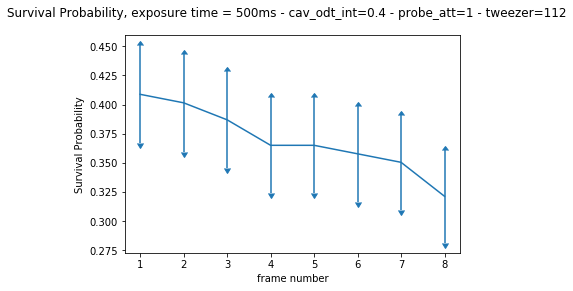

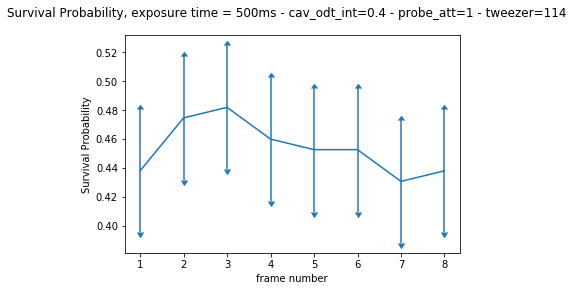

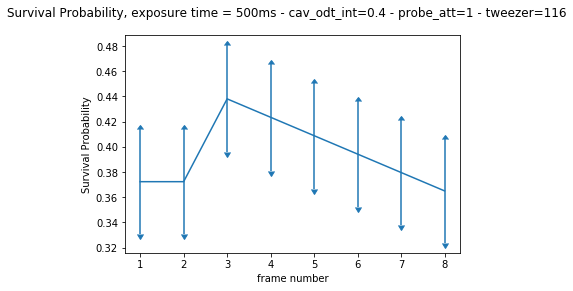

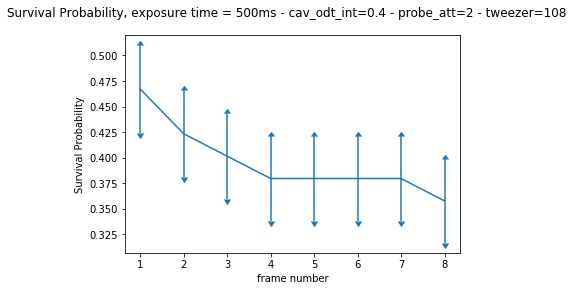

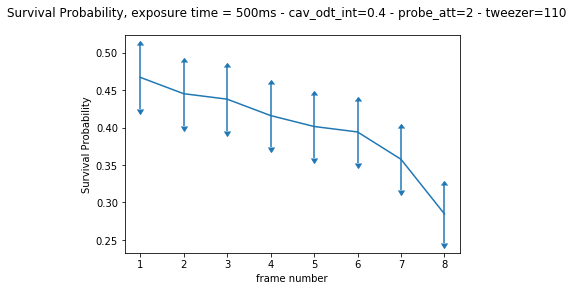

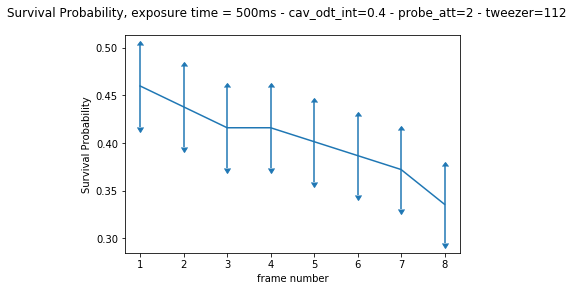

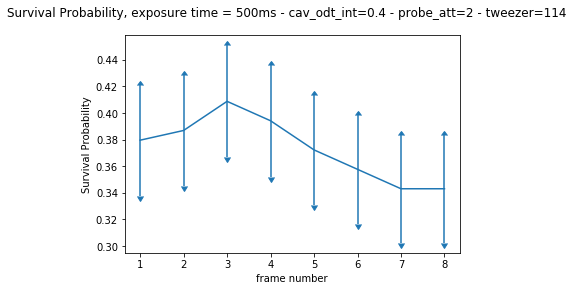

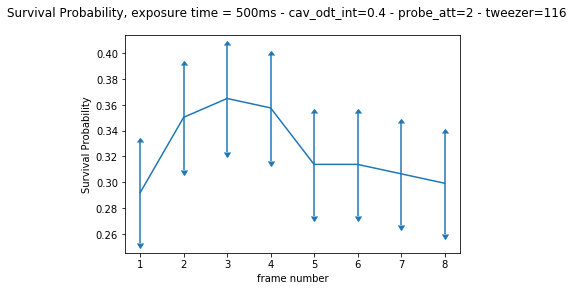

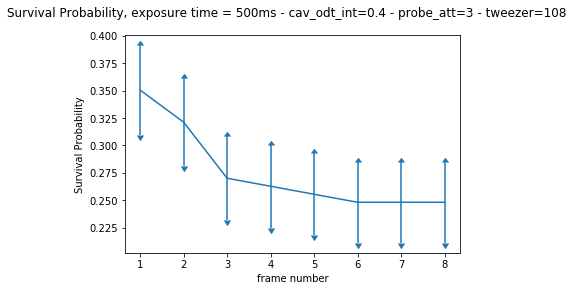

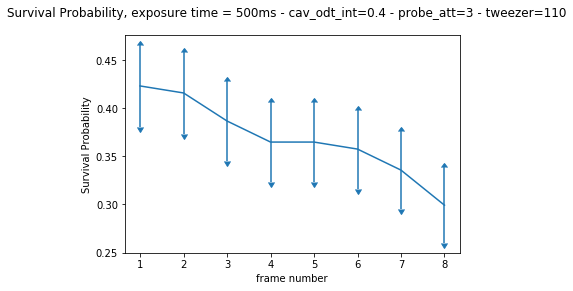

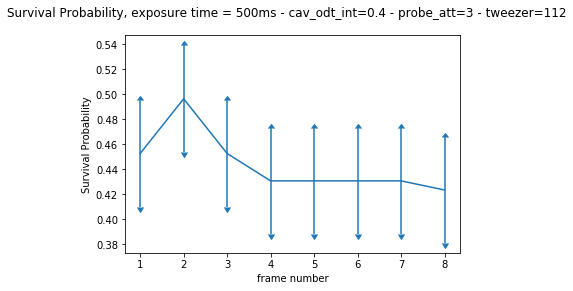

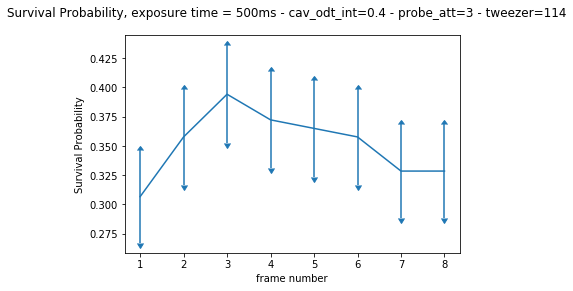

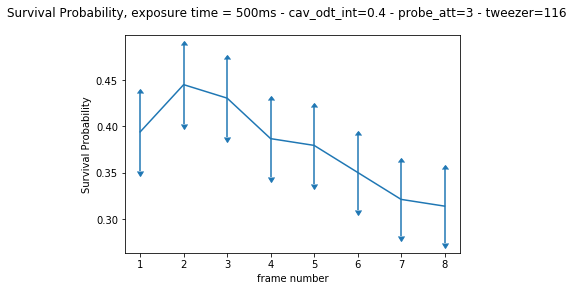

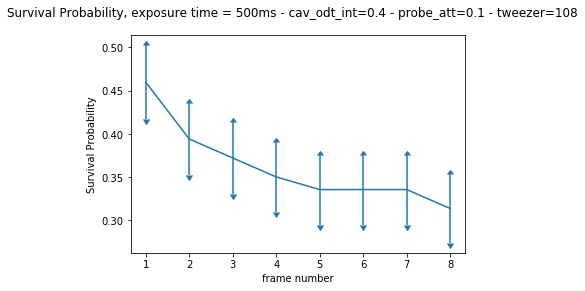

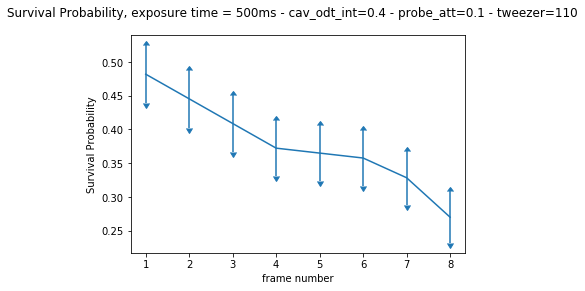

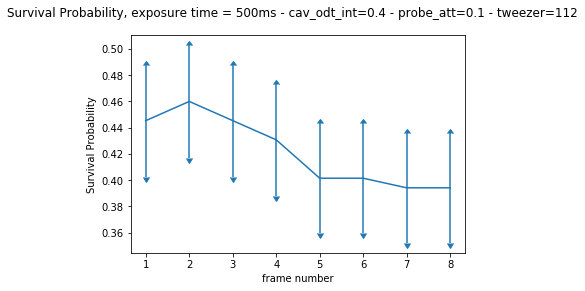

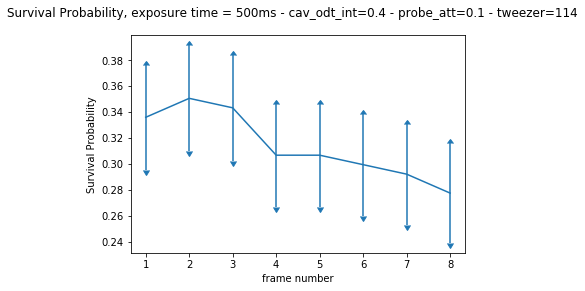

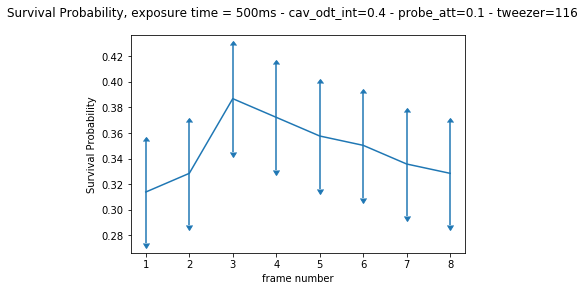

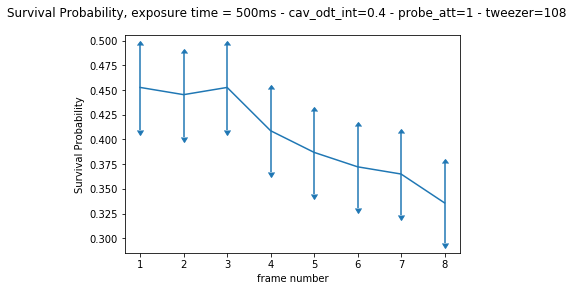

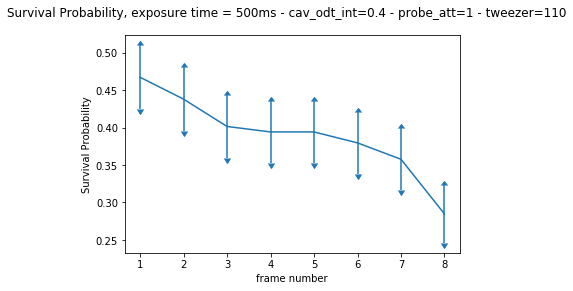

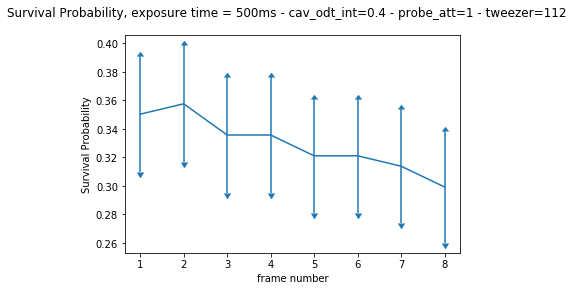

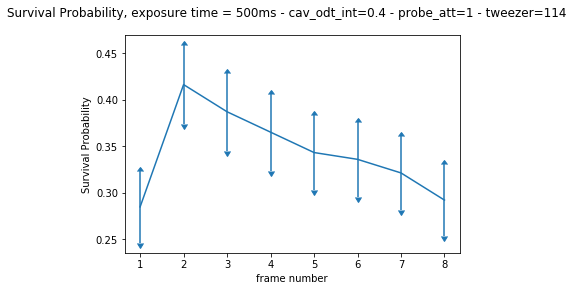

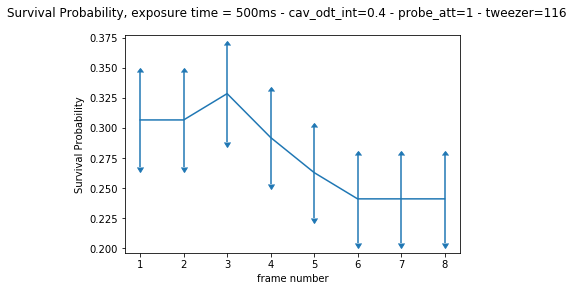

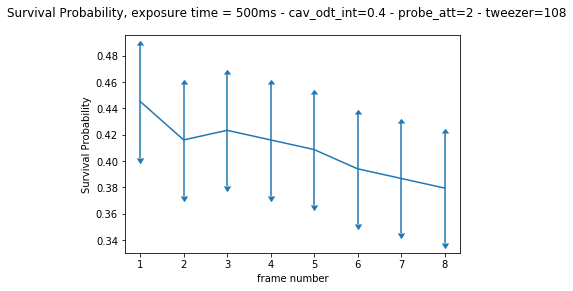

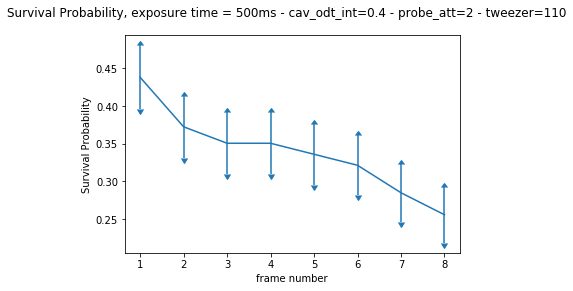

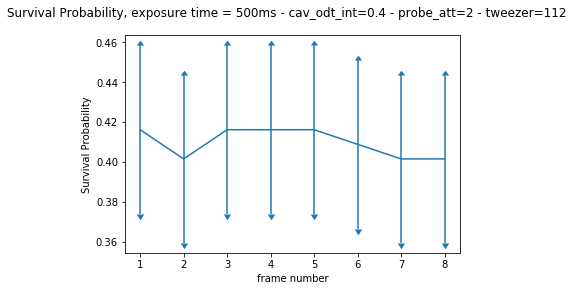

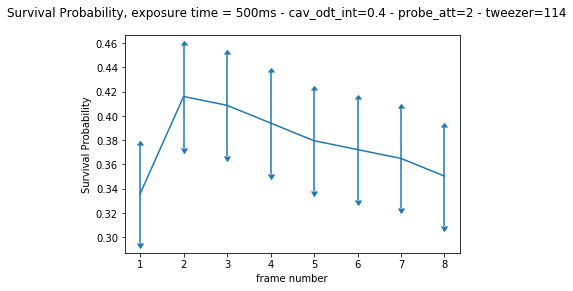

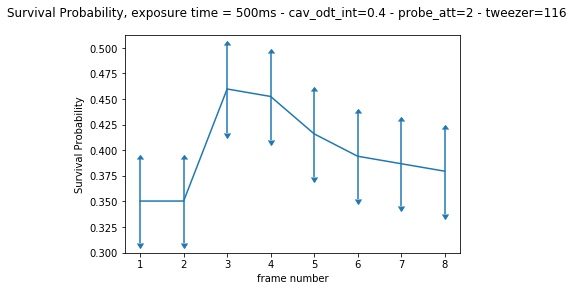

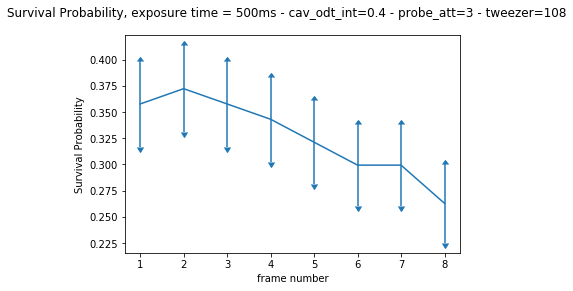

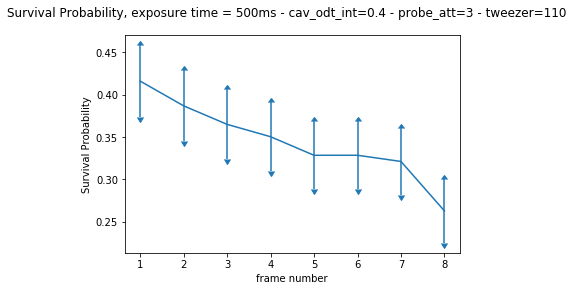

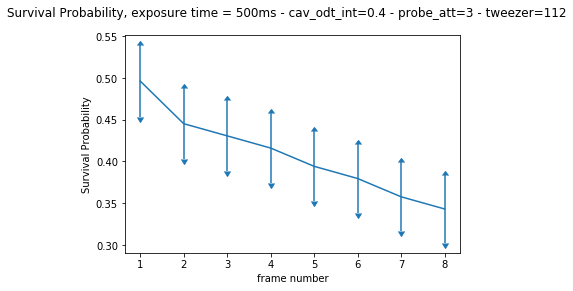

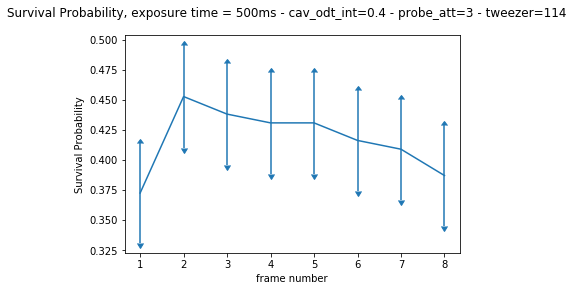

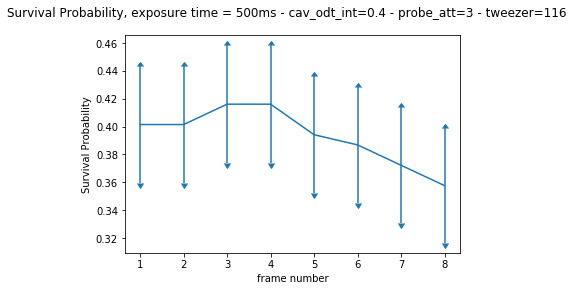

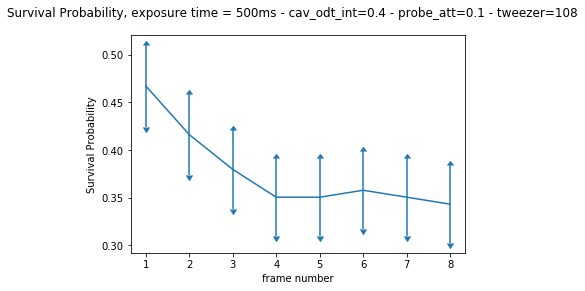

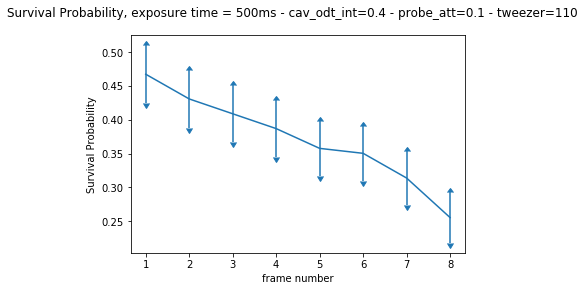

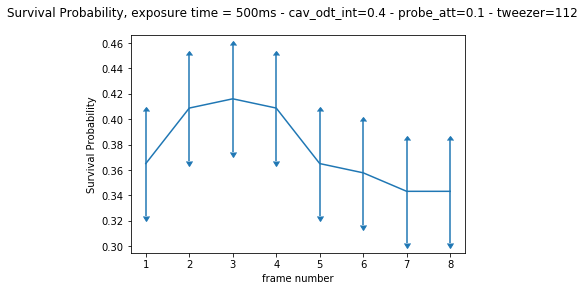

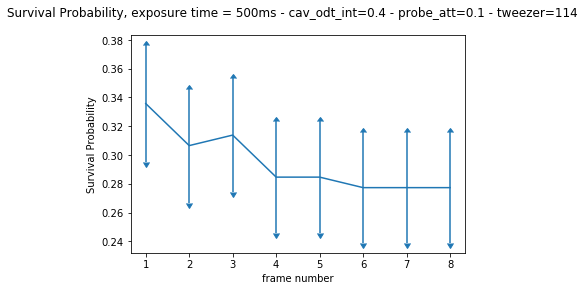

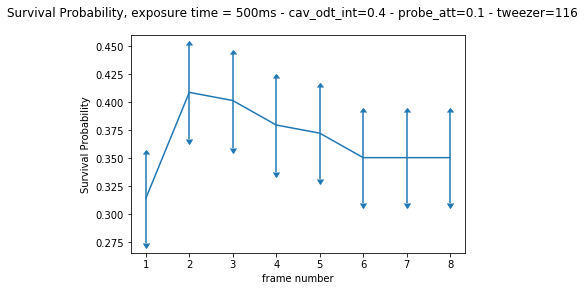

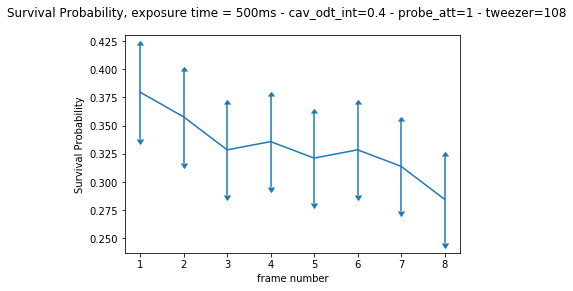

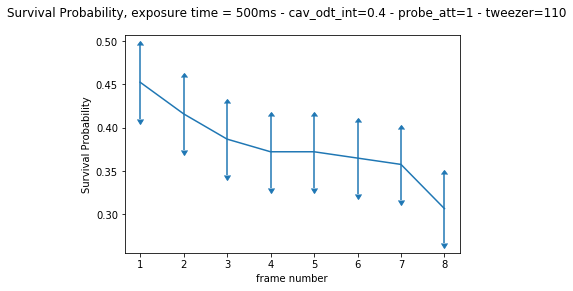

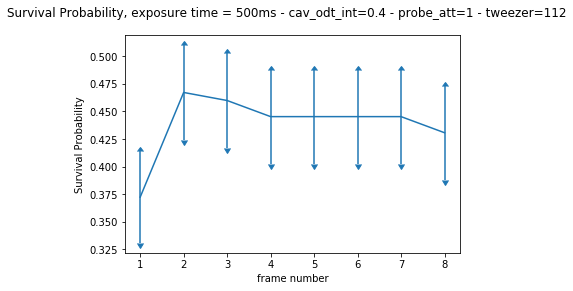

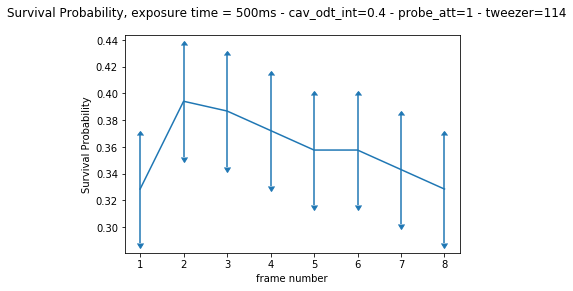

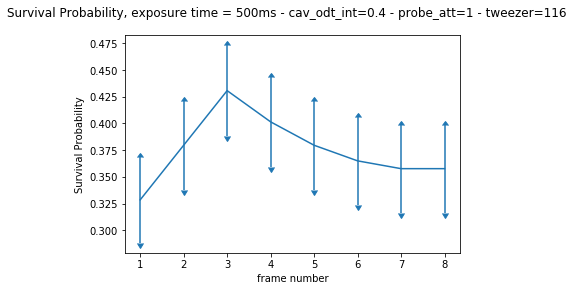

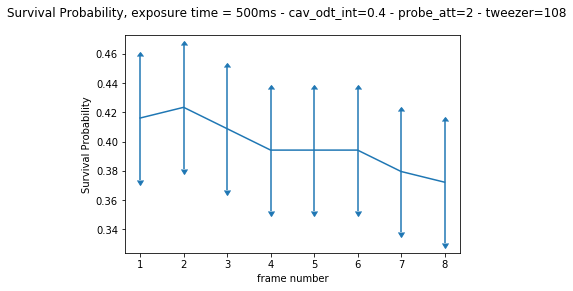

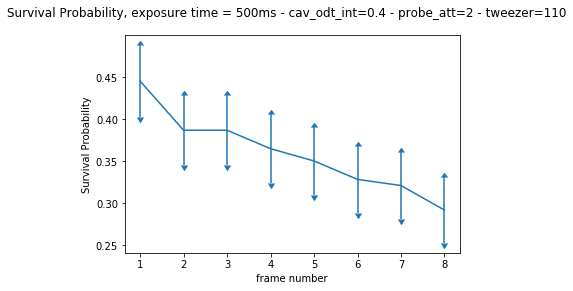

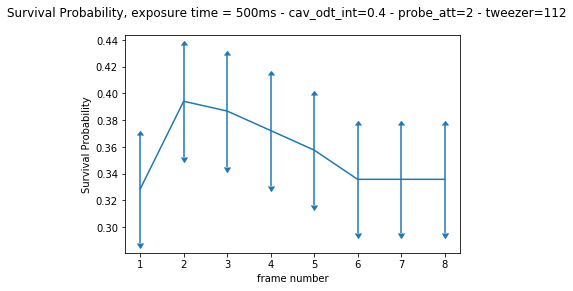

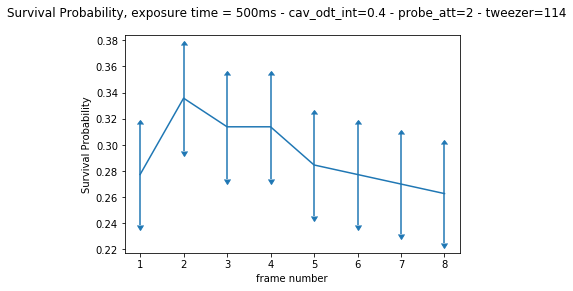

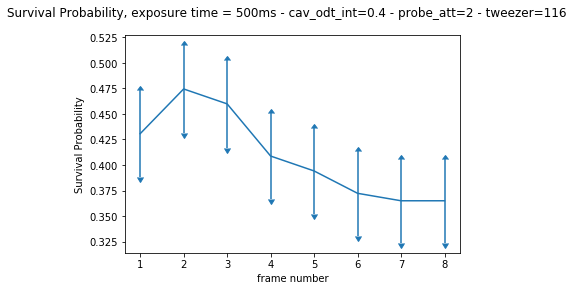

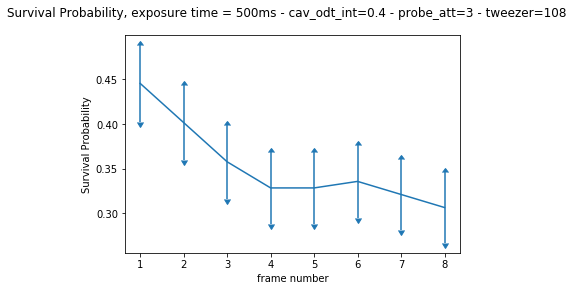

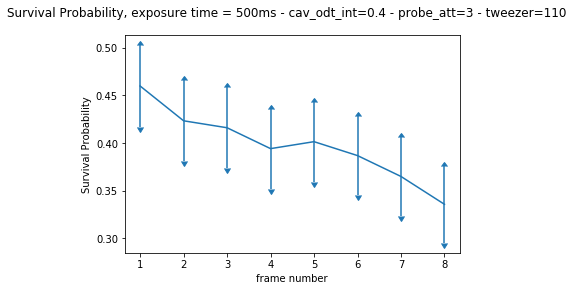

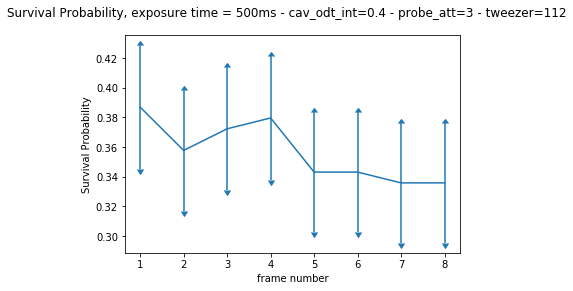

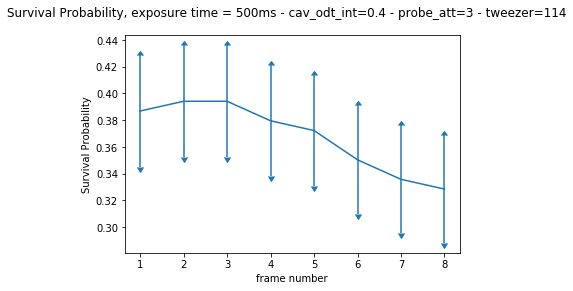

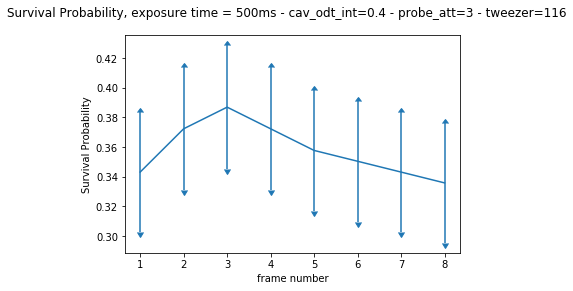

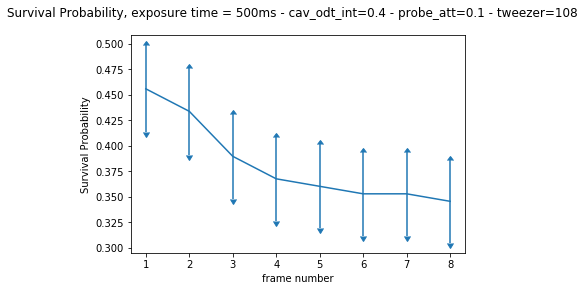

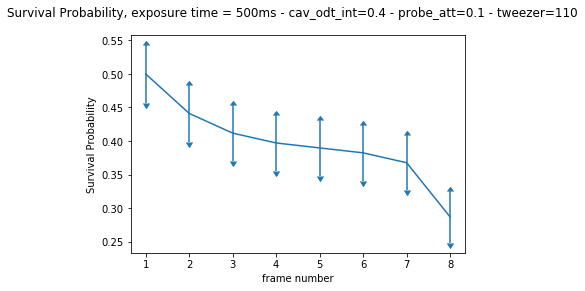

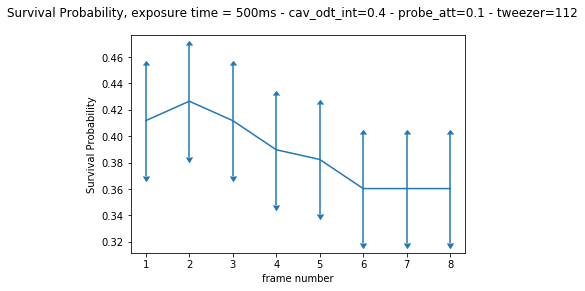

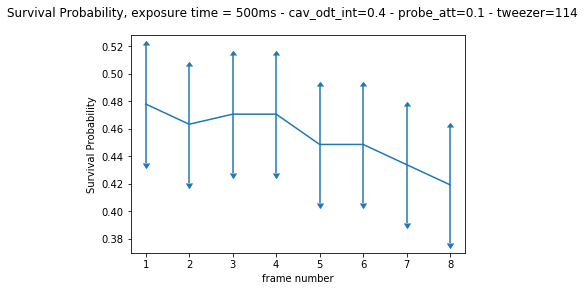

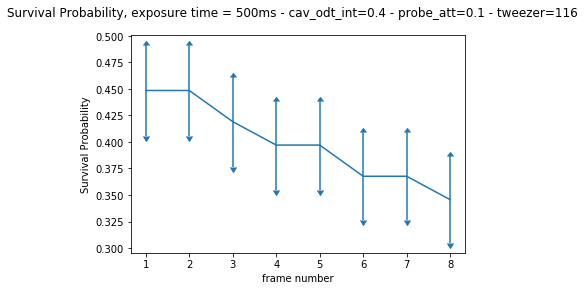

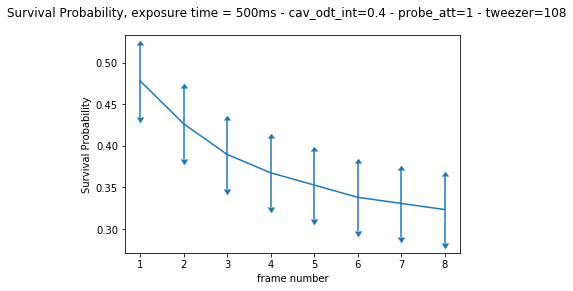

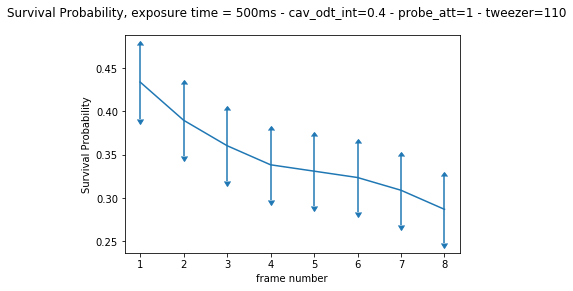

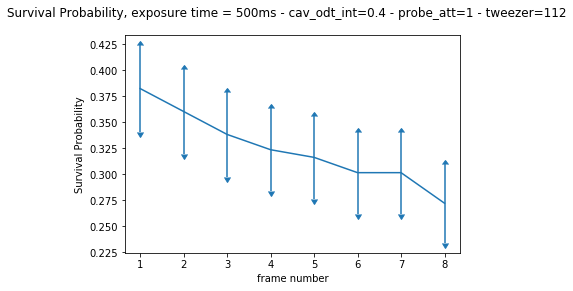

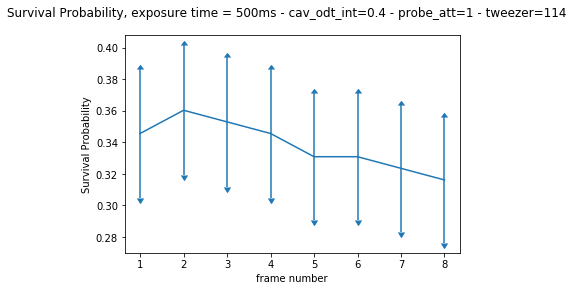

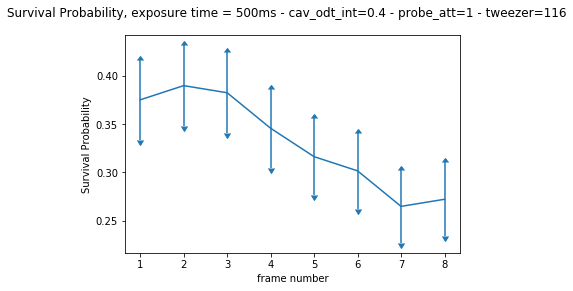

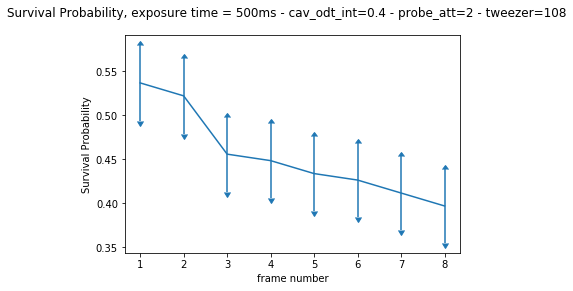

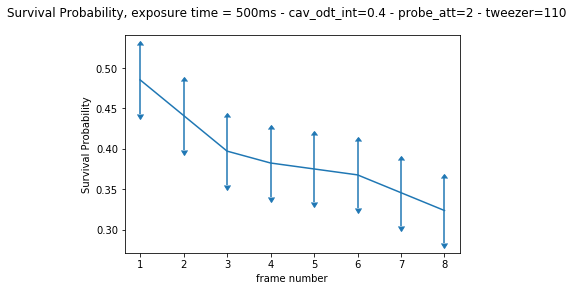

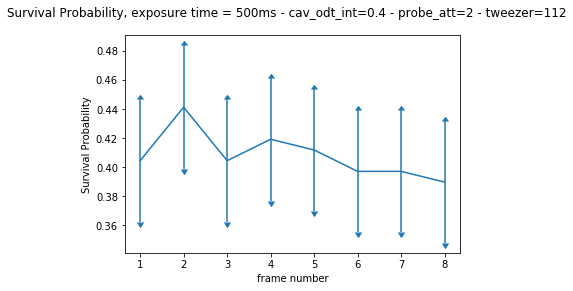

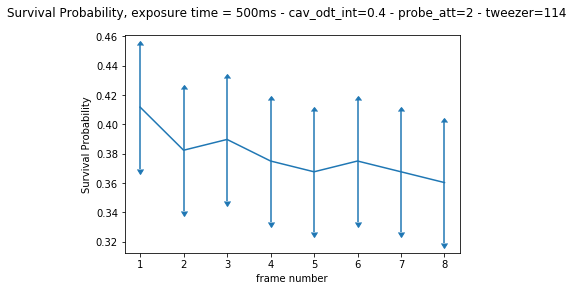

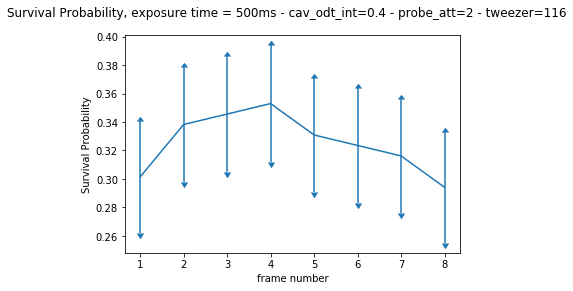

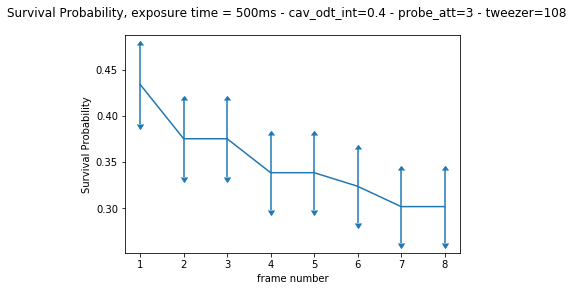

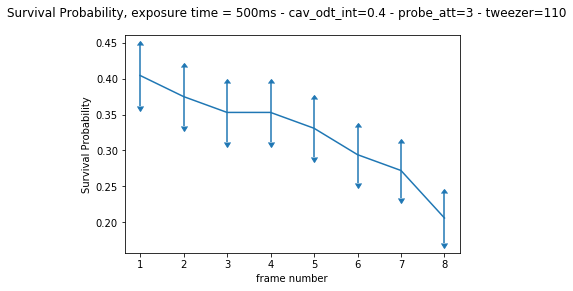

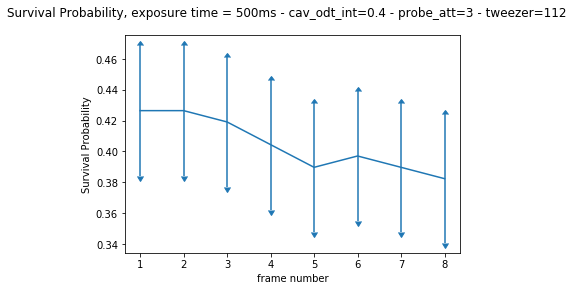

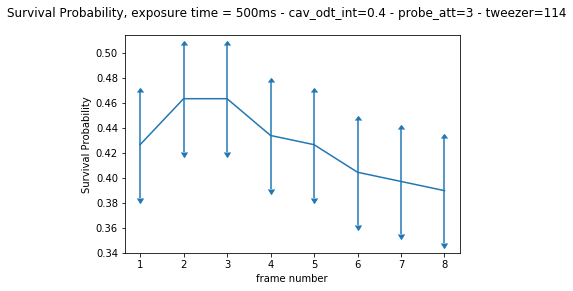

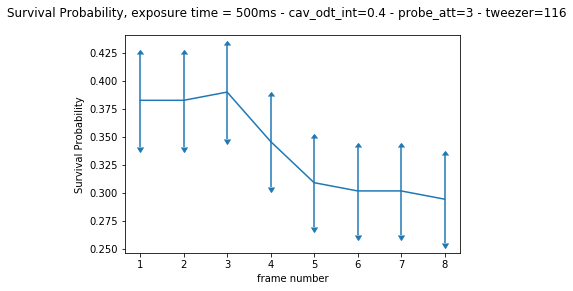

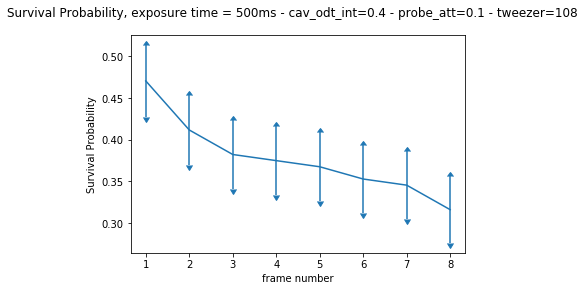

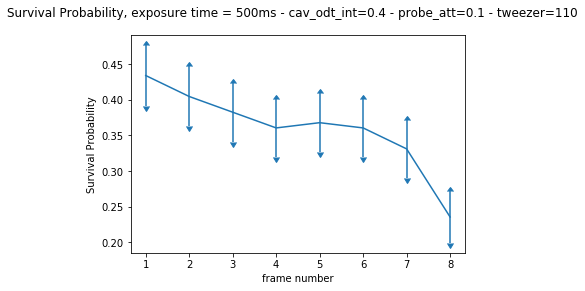

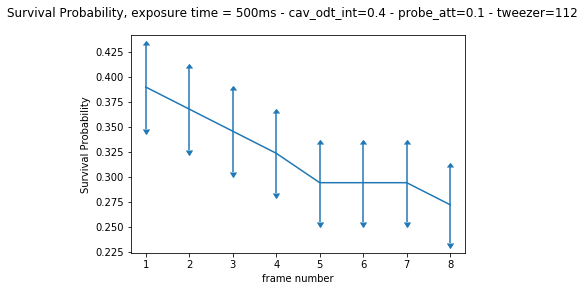

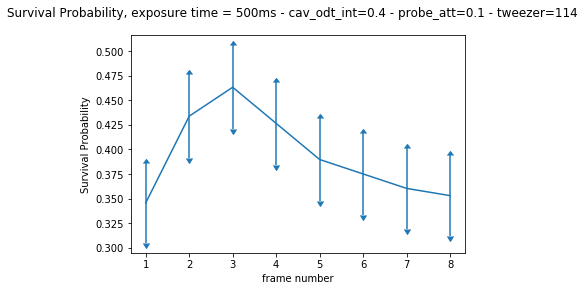

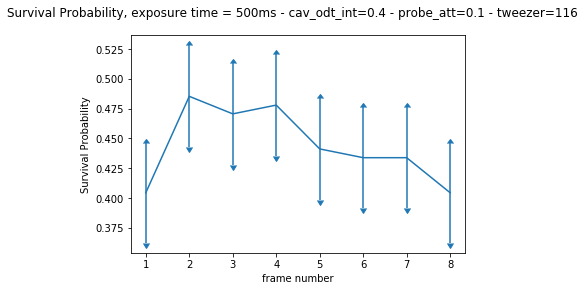

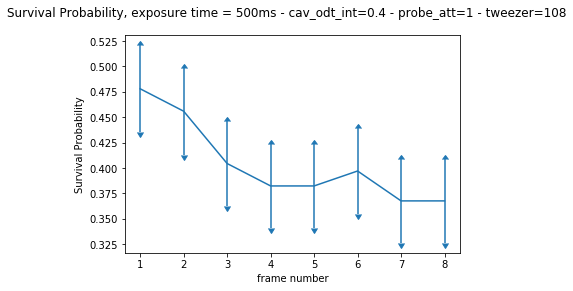

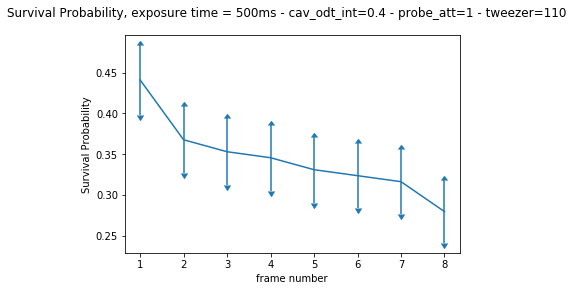

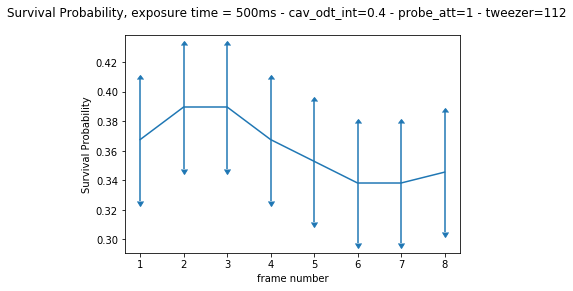

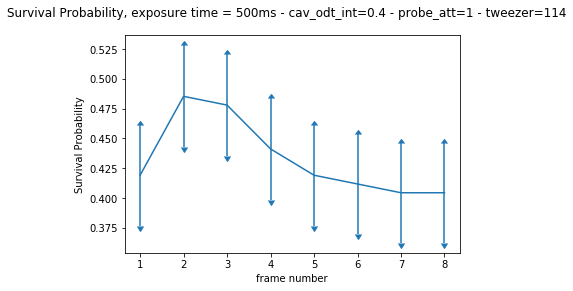

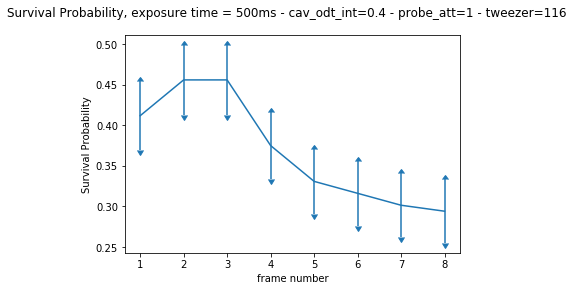

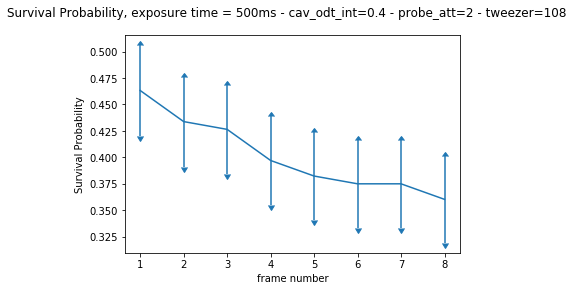

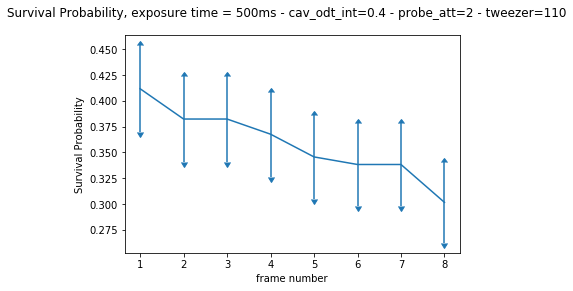

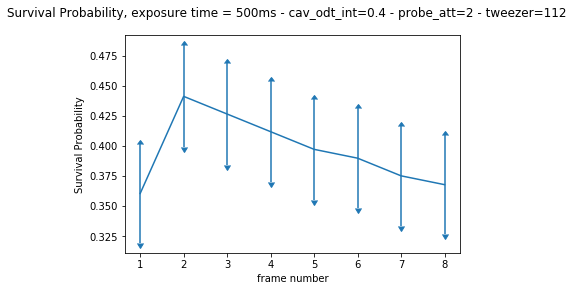

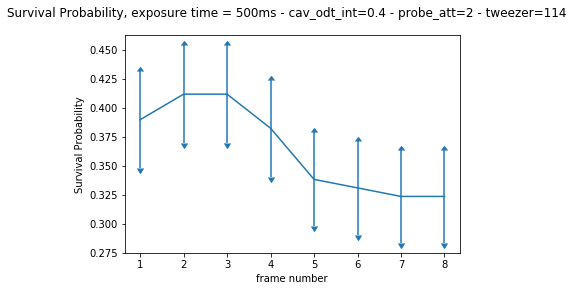

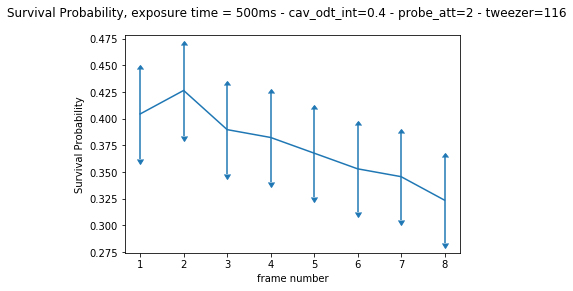

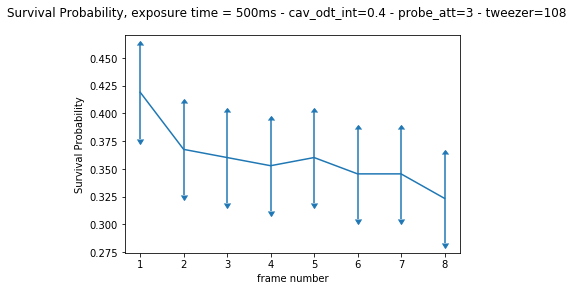

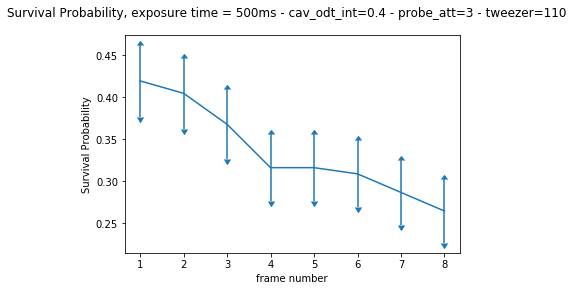

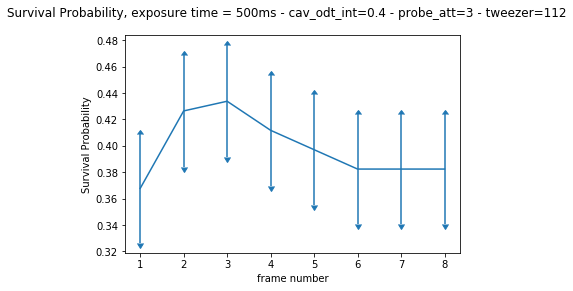

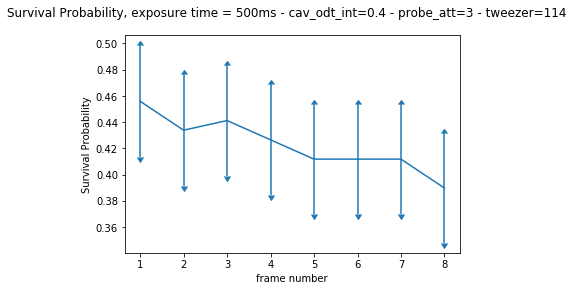

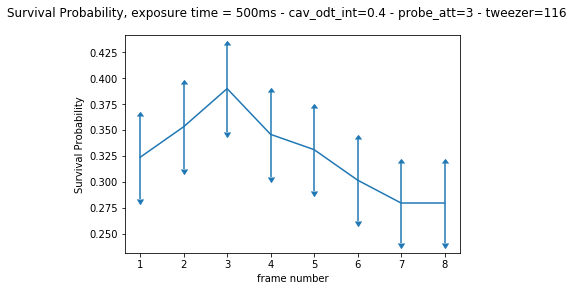

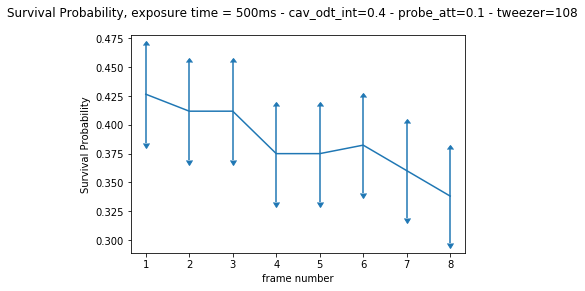

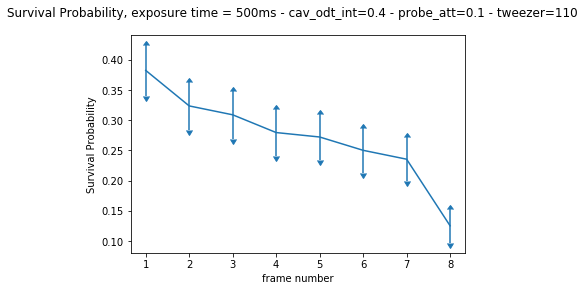

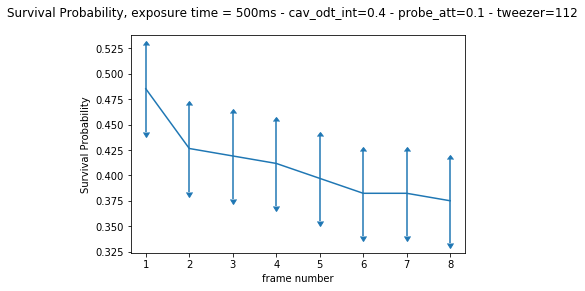

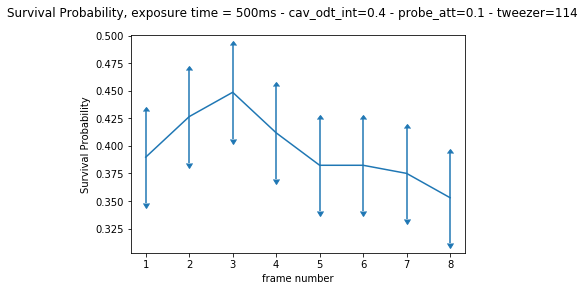

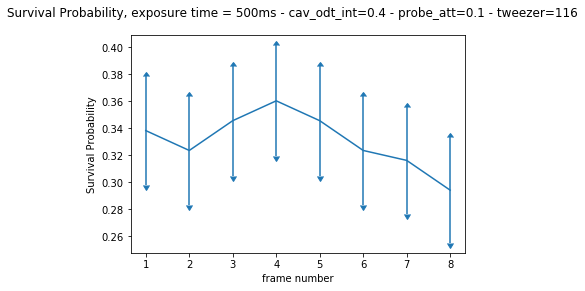

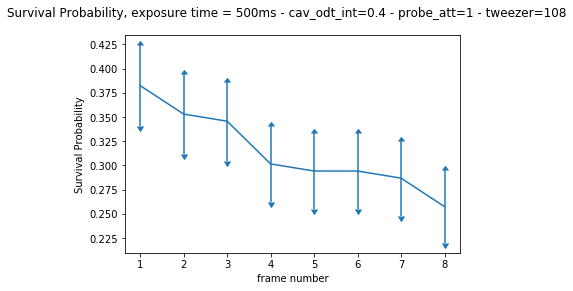

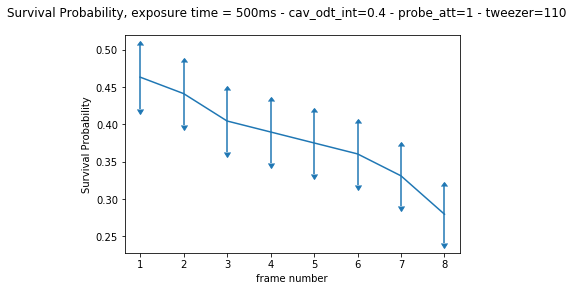

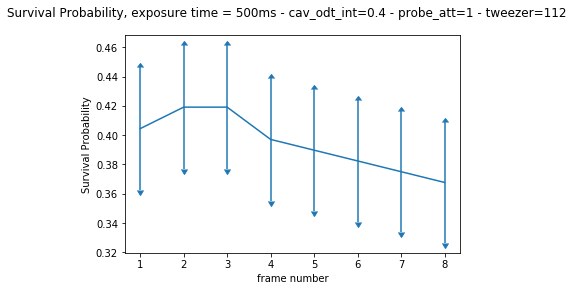

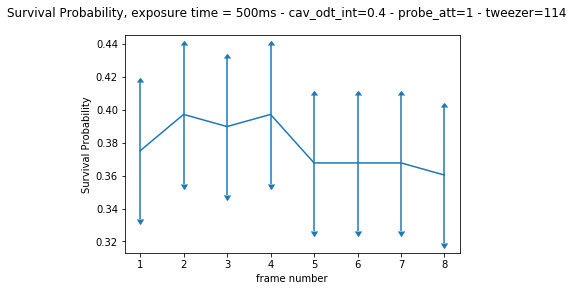

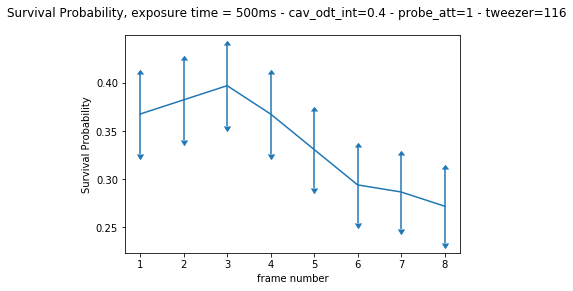

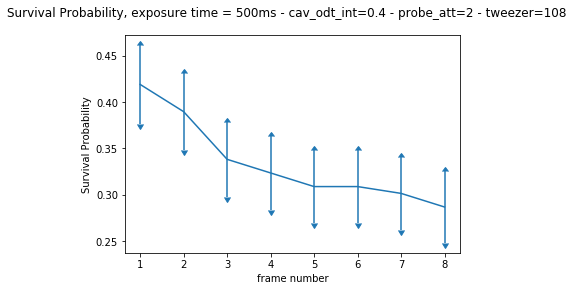

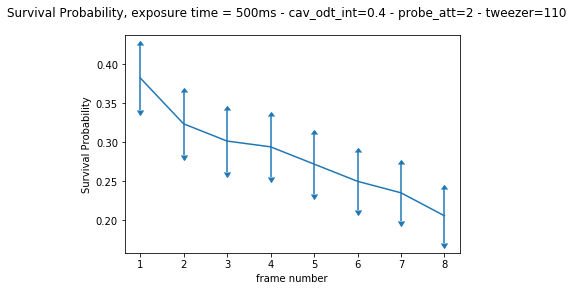

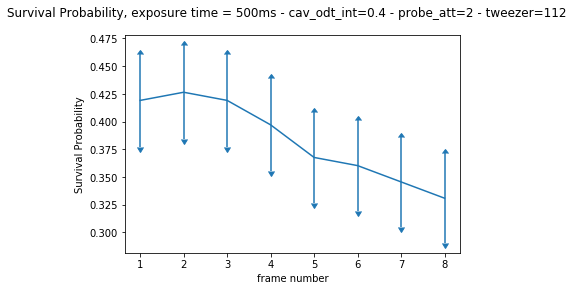

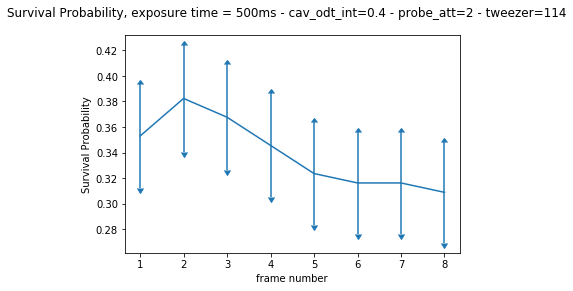

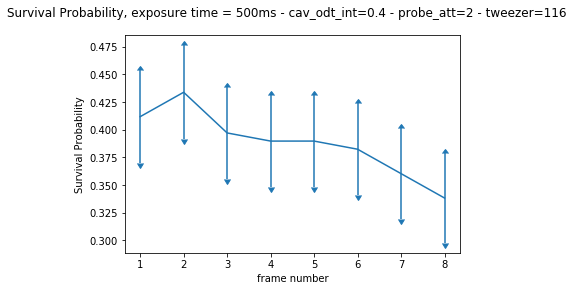

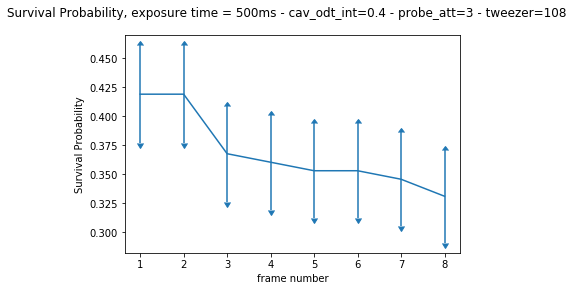

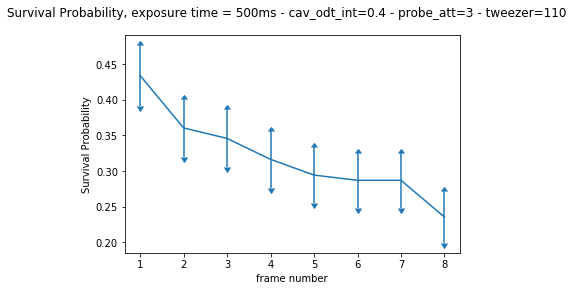

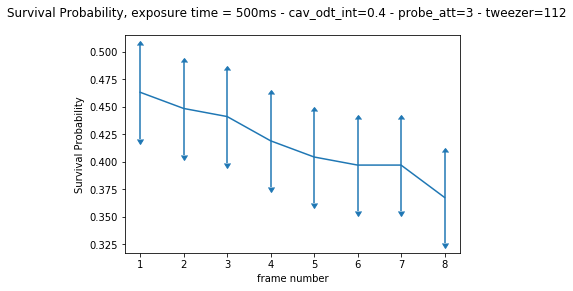

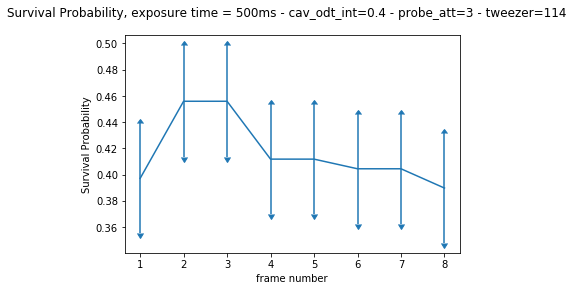

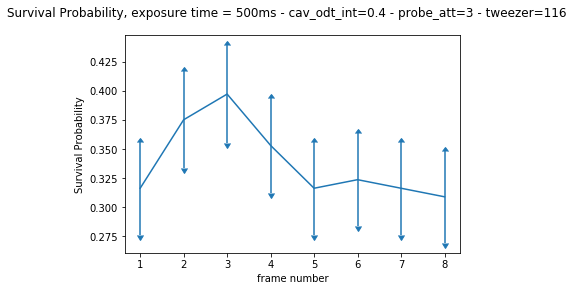

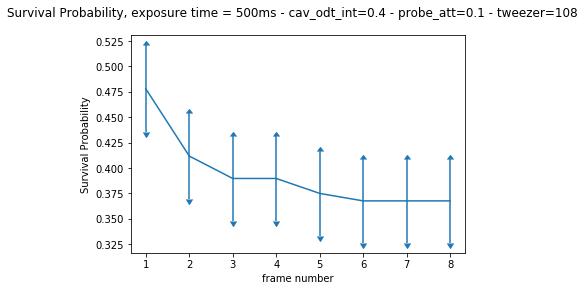

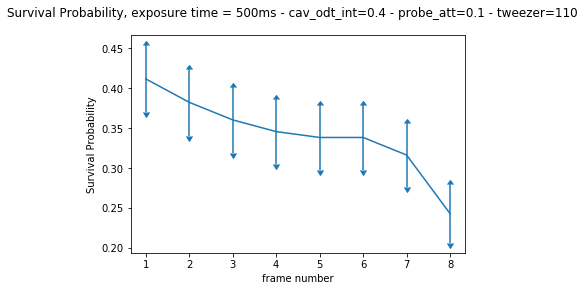

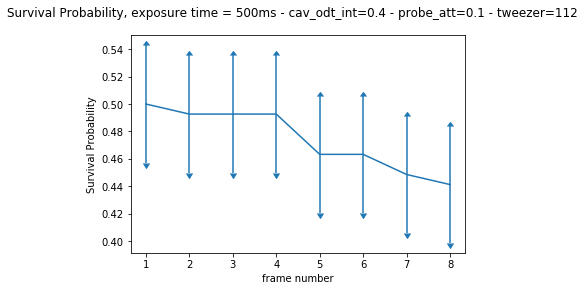

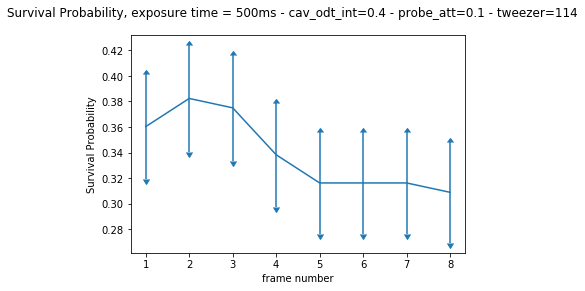

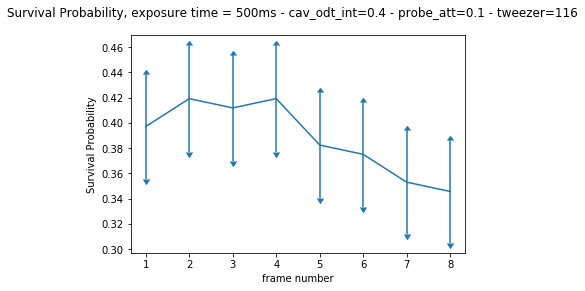

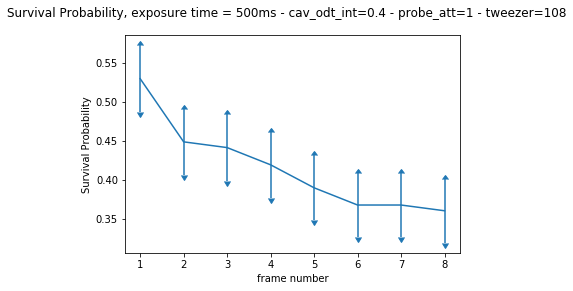

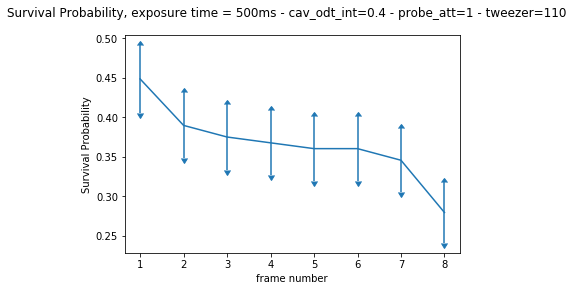

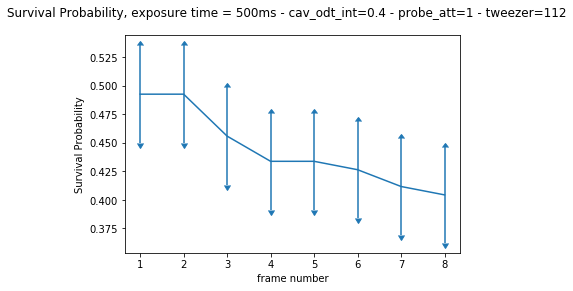

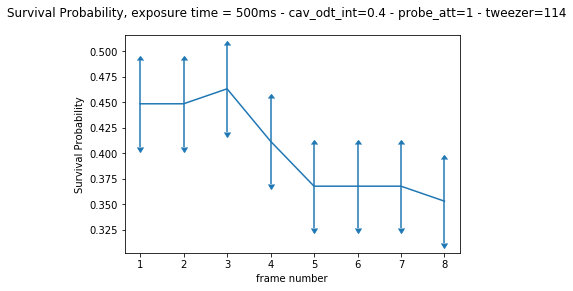

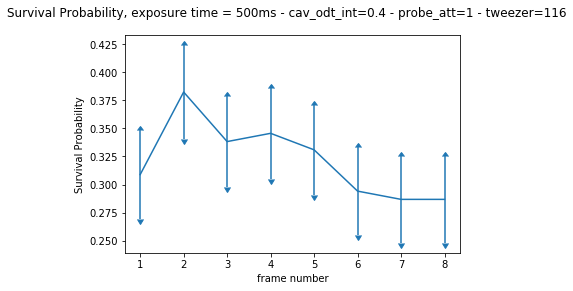

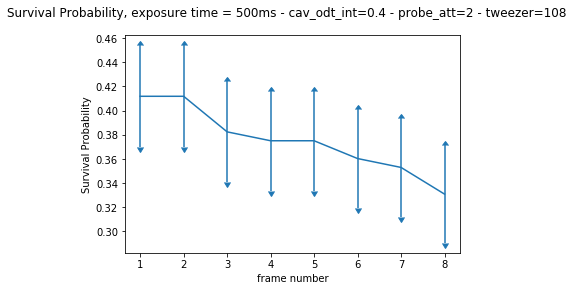

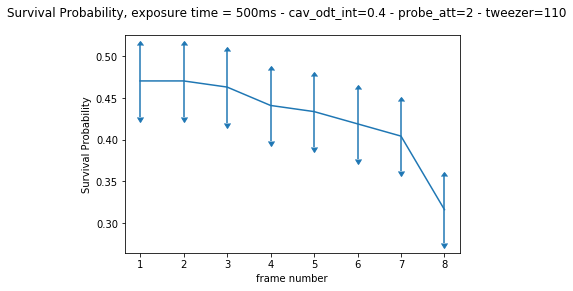

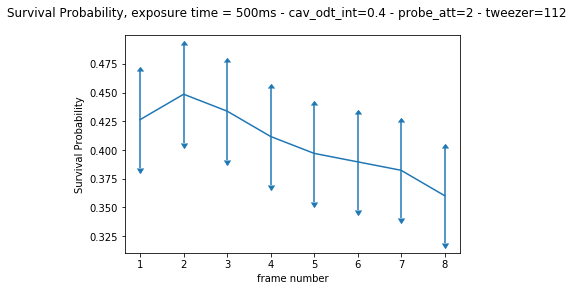

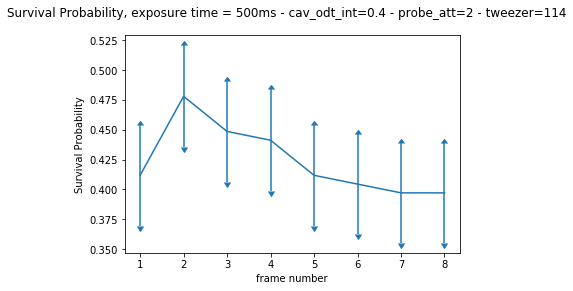

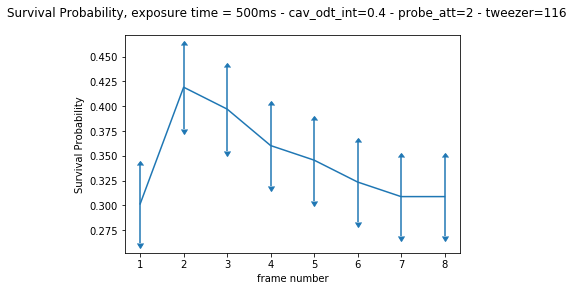

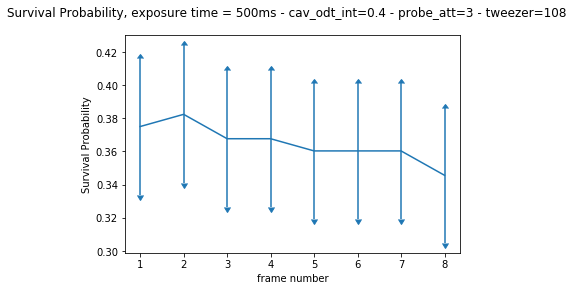

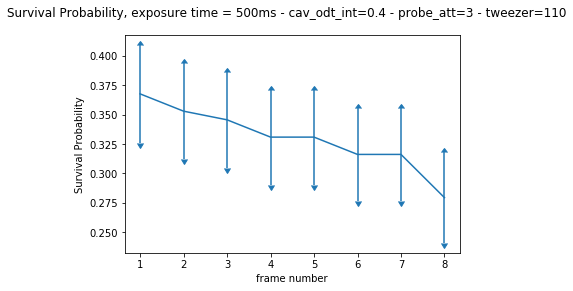

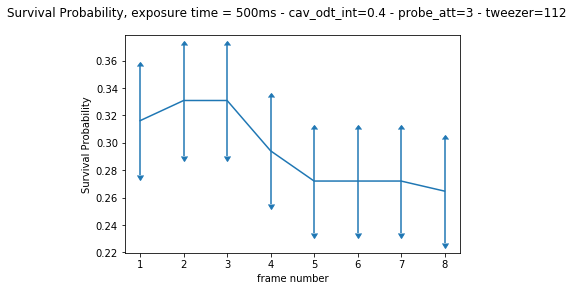

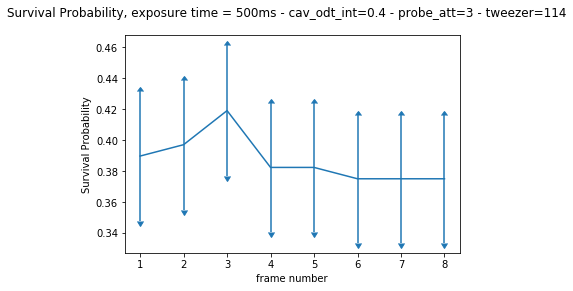

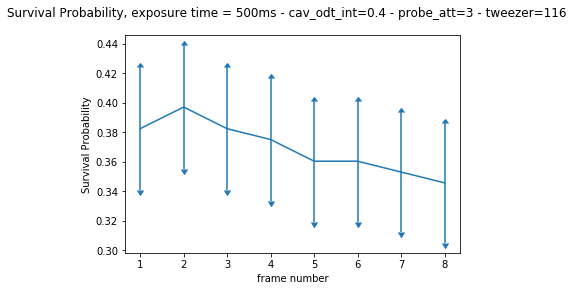

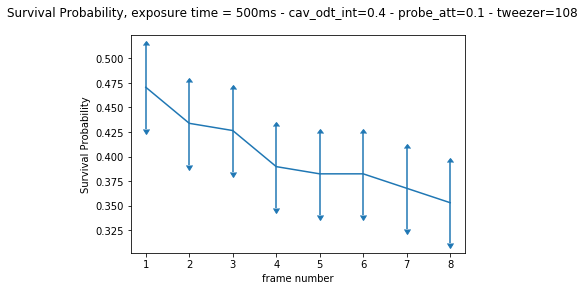

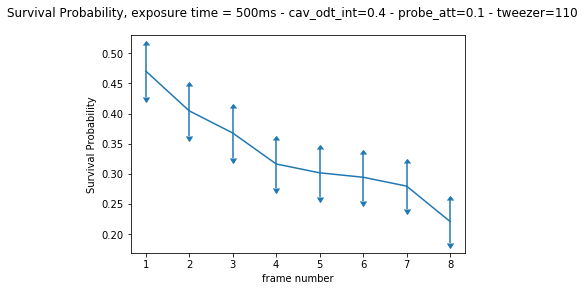

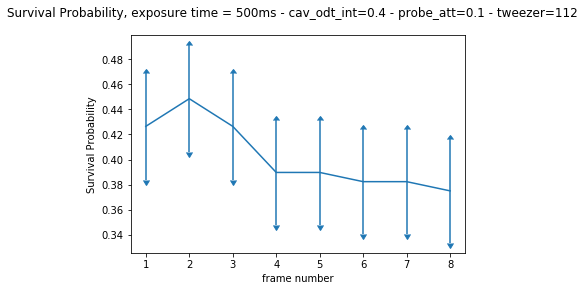

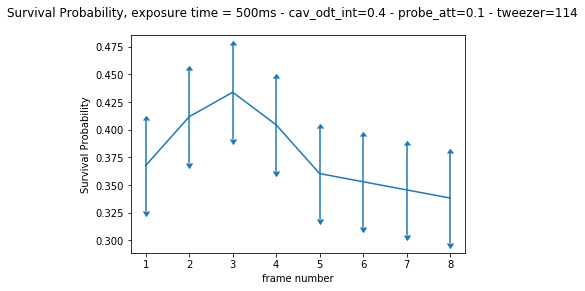

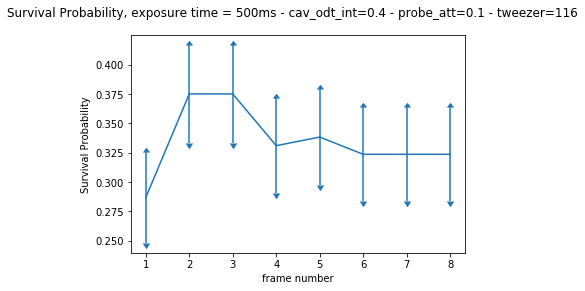

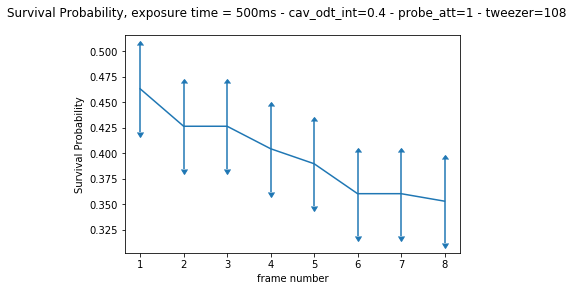

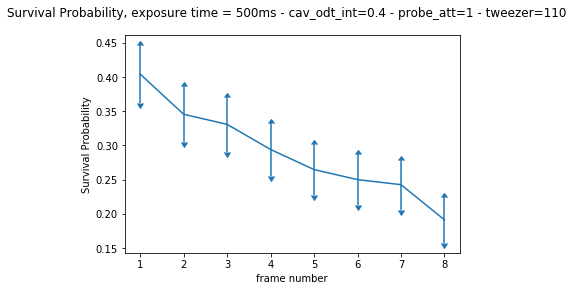

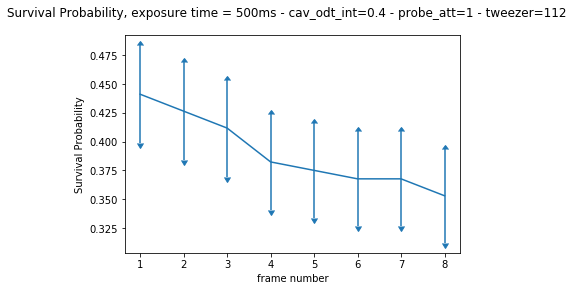

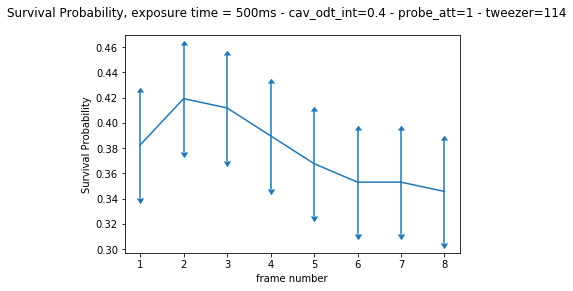

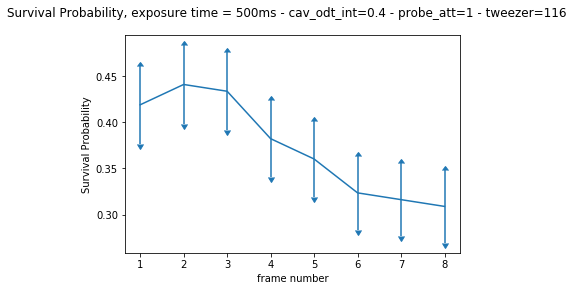

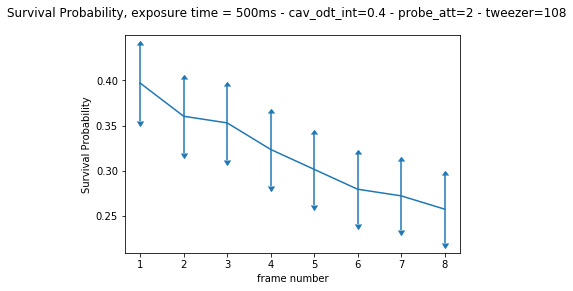

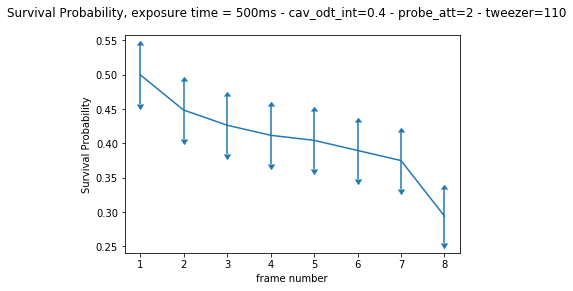

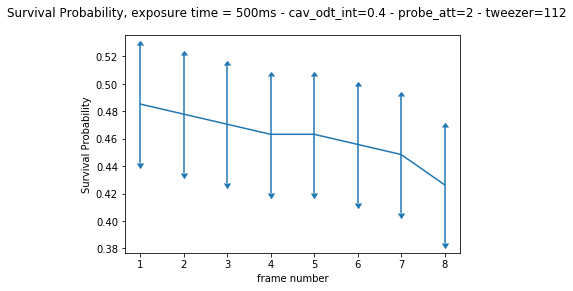

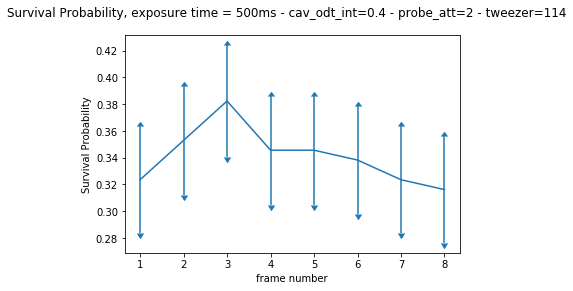

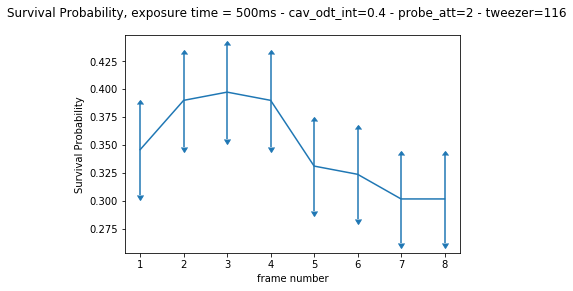

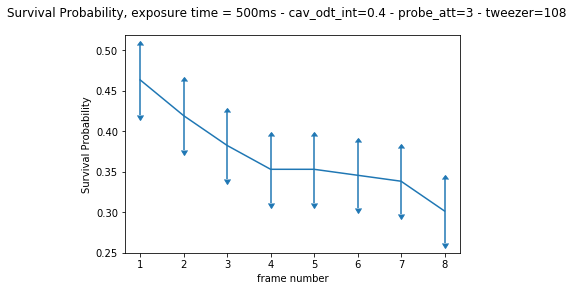

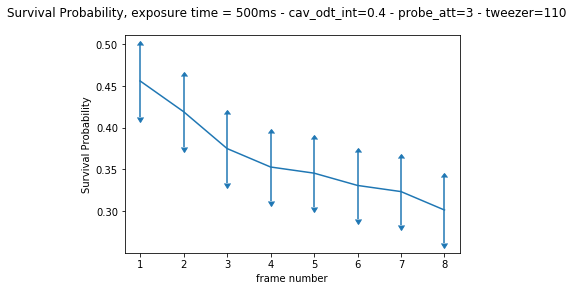

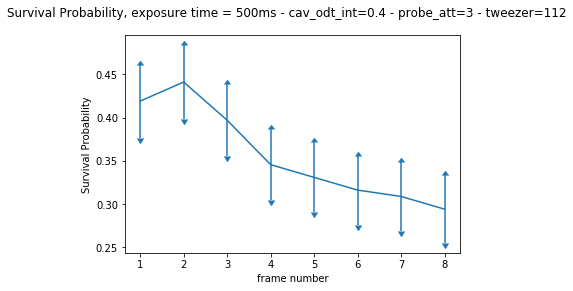

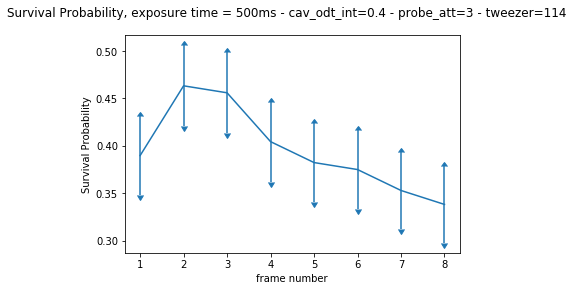

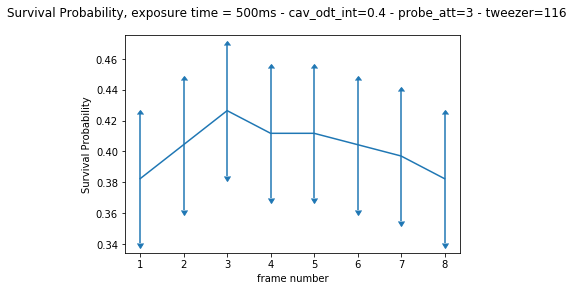

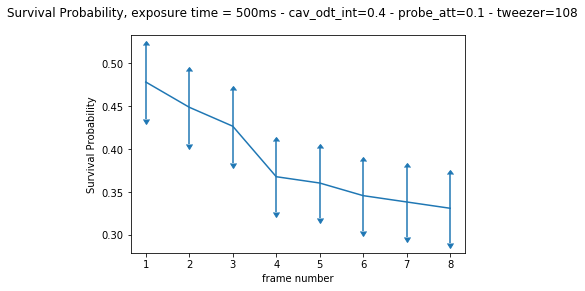

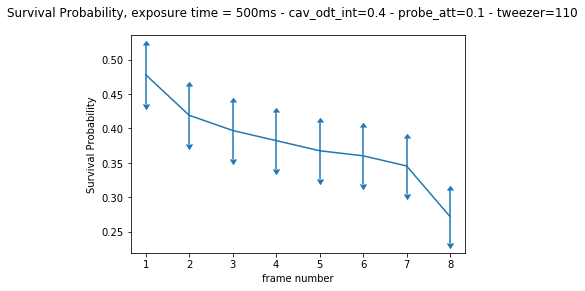

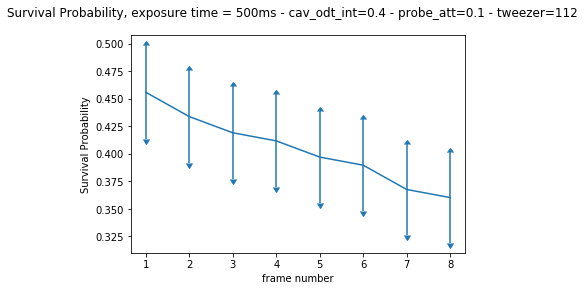

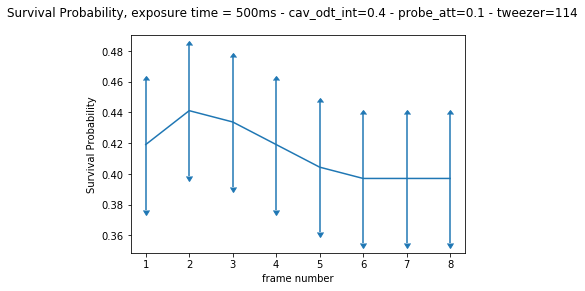

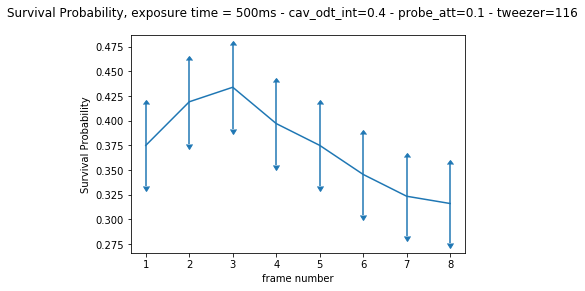

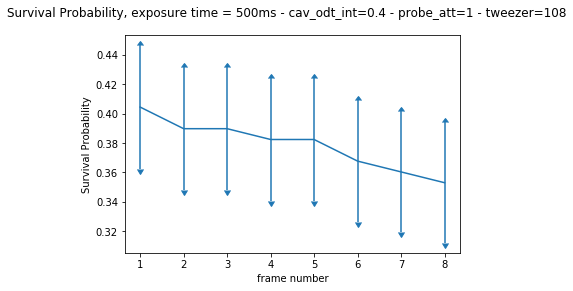

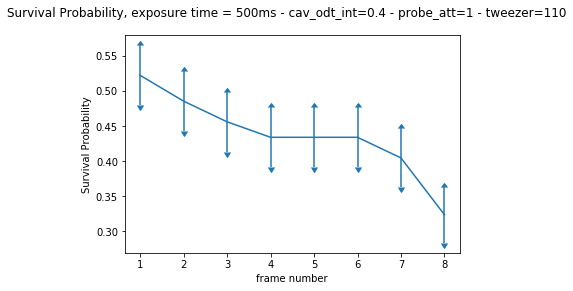

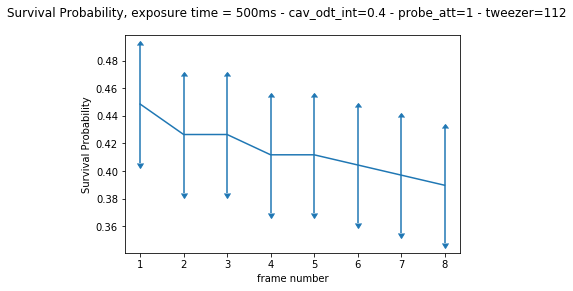

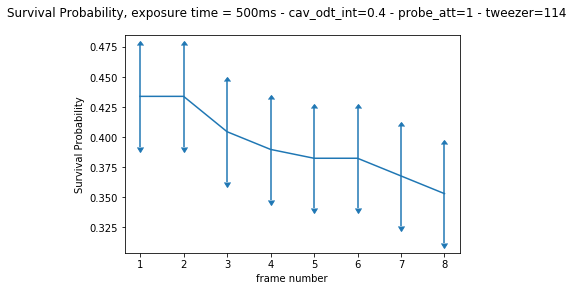

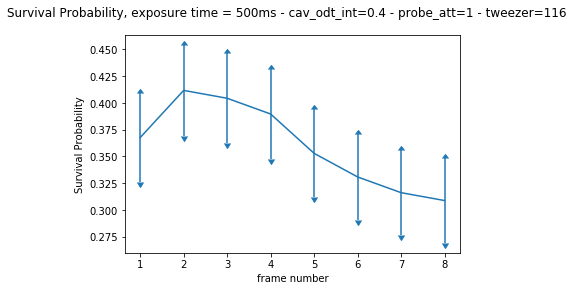

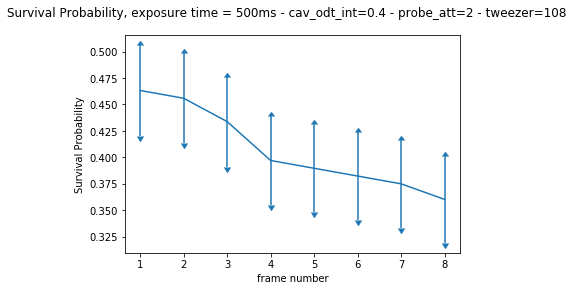

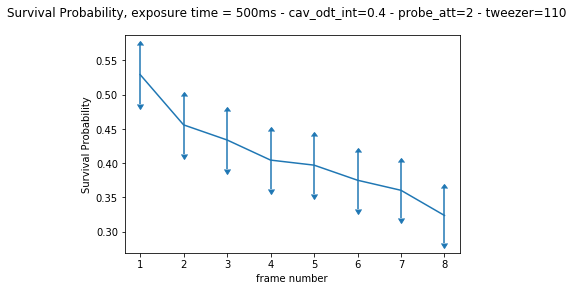

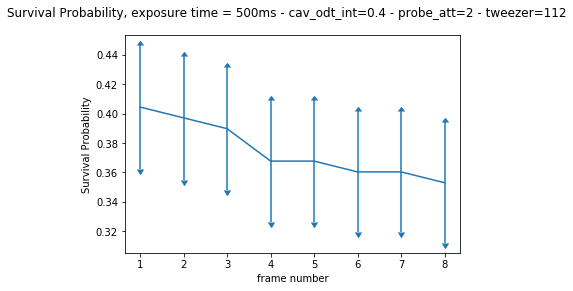

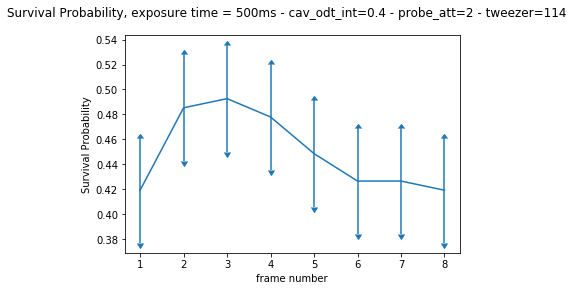

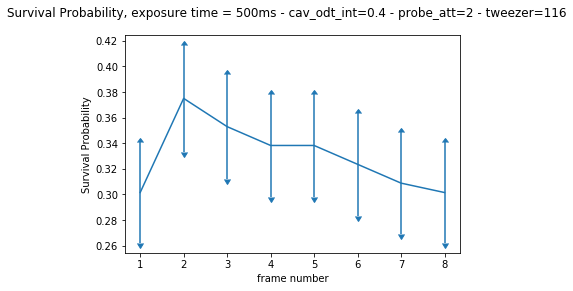

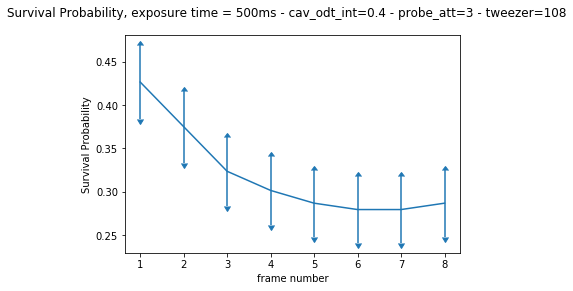

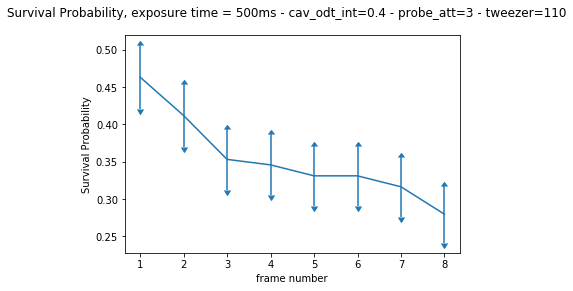

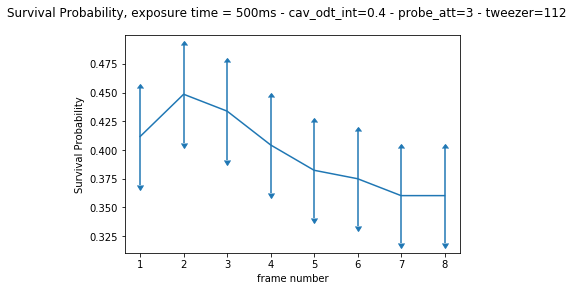

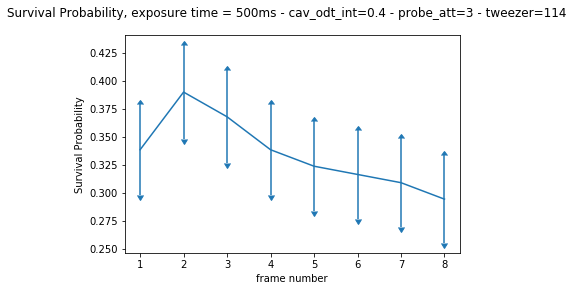

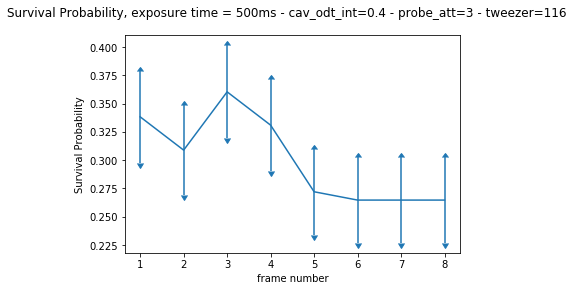

In [12]:
quiet = True

num_loops = (num_shots-1)//num_points
cav_fidelity = np.zeros((len(mol_freq_list), len(probe_att_list), len(pzt_para_list),len(tweezer_freq_list)))
cav_fidelity_sigma = np.zeros((len(mol_freq_list), len(probe_att_list), len(pzt_para_list),len(tweezer_freq_list)))
cav_brightness = np.zeros((len(mol_freq_list), len(probe_att_list), len(pzt_para_list),len(tweezer_freq_list)))
cav_brightness_sigma = np.zeros((len(mol_freq_list), len(probe_att_list), len(pzt_para_list),len(tweezer_freq_list)))


for point in range(num_points):
    probe_att_counter = point % len(probe_att_list)
    probe_att = probe_att_list[probe_att_counter]
    pzt_para_counter = point // len(probe_att_list)
    pzt_para = pzt_para_list[pzt_para_counter]
    
    firstframe_prob = np.zeros( len(tweezer_freq_list))
    fidelity = np.zeros((len(mol_freq_list), len(tweezer_freq_list)))
    sigma_fidelity = np.zeros((len(mol_freq_list), len(tweezer_freq_list)))
    brightness = np.zeros((len(mol_freq_list), len(tweezer_freq_list)))
    sigma_brightness = np.zeros((len(mol_freq_list), len(tweezer_freq_list)))

    tweezer_counter = -1
    for tweezer in tweezer_freq_list:
        tweezer_counter += 1

        zeropeakHWFMper = 1.5
        base = np.average(counts_dict[point][num_frames - 1][tweezer_counter])
        upper_threshold = base + 1.2 * zeropeakHWFMper * roi_area

        ref_counts = np.array(counts_dict[point][num_frames - 1][tweezer_counter])
        counts_1 = np.array(counts_dict[point][0][tweezer_counter])
        for frame_num in range(num_frames - 2):
            mol_freq = mol_freq_list[frame_num]
            counts = np.array(counts_dict[point][frame_num][tweezer_counter])
            counts_next = np.array(counts_dict[point][frame_num+1][tweezer_counter])
            mask = counts_next > upper_threshold
            counts_post_selected = counts[mask]
#                 lower_threshold = 0

            if len(counts_post_selected) == 0: 
                brightness[frame_num, tweezer_counter] = -0
                sigma_brightness[frame_num, tweezer_counter] = 0
                lower_threshold = 0
            else:
                atomcenter = np.nanmean(counts_post_selected)
                brightness[frame_num, tweezer_counter] = atomcenter - base
                sigma_brightness[frame_num, tweezer_counter] = np.std(counts_post_selected)
                lower_threshold = atomcenter - 3 * sigma_brightness[frame_num, tweezer_counter]
                
            mask = counts_post_selected > lower_threshold
            counts_postpost_selected = counts_post_selected[mask]
            
            
            if len(counts_postpost_selected) == 0: 
                brightness[frame_num, tweezer_counter] = -0
                sigma_brightness[frame_num, tweezer_counter] = 0
                lower_threshold = 0
            else:
                atomcenter = np.nanmean(counts_postpost_selected)
                brightness[frame_num, tweezer_counter] = atomcenter - base
                sigma_brightness[frame_num, tweezer_counter] = np.std(counts_postpost_selected)
                lower_threshold = atomcenter - 3 * sigma_brightness[frame_num, tweezer_counter]

            cav_brightness[frame_num, probe_att_counter, pzt_para_counter, tweezer_counter] = brightness[frame_num, tweezer_counter]
            cav_brightness_sigma[frame_num, probe_att_counter, pzt_para_counter, tweezer_counter] = sigma_brightness[frame_num, tweezer_counter]
            fidelity_temp =  len(counts[counts > upper_threshold])/len(counts)
            fidelity[frame_num, tweezer_counter] = fidelity_temp 
            sigma_fidelity[frame_num, tweezer_counter] = np.sqrt(num_loops*fidelity_temp*(1-fidelity_temp))/(num_loops)
            cav_fidelity[frame_num, probe_att_counter, pzt_para_counter, tweezer_counter] = fidelity[frame_num, tweezer_counter]
            cav_fidelity_sigma[frame_num, probe_att_counter, pzt_para_counter, tweezer_counter] = sigma_fidelity[frame_num, tweezer_counter]
            if quiet == False and pzt_para_counter == 6:
                    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
                    fig.suptitle(f'counts histogram - cav_odt_int=0.4 - mol_freq={mol_freq} - probe_att={probe_att} - pzt_para={pzt_para} - tweezer={tweezer} - frame_{frame_num + 1} survival P = {"%0.3f" % fidelity_temp}')
                    
                    bins=50
                    ax[0].hist(counts_1, alpha=0.15, color='yellow', bins=bins)
                    ax[0].hist(ref_counts, alpha=0.3, color='b', bins=bins)
                    n, bins, patches = ax[0].hist(counts, alpha=0.6, color='r', bins=bins)
                    ax[0].hist(counts_postpost_selected, alpha=0.5, color='black', bins=bins)
                    ax[0].legend(['counts_1', 'counts_ref', f'counts_{frame_num + 1}', f'counts_{frame_num + 1}(post selected)'])
                    ax[0].axvline(upper_threshold, linestyle='--', color='k')
#                     ax[0].axvline(lower_threshold, linestyle='--', color='b')

                    scatter_range = range(len(ref_counts))
                    ax[1].scatter(scatter_range, counts, color='r')
                    ax[1].scatter(scatter_range, ref_counts, color='b')
                    ax[1].set_xlabel('loop number')
                    ax[1].set_ylabel('photon counts')
                               
#                     plt.savefig(Path(save_path, f'mol_freq={mol_freq} - pzt_para={pzt_para_counter} - tweezer={tweezer_counter} - frame_2_pre_selected.png'))
                    plt.show()

        if True:
            fig, ax = plt.subplots(1,1)
            ax.errorbar(range(1,len(mol_freq_list)+1),fidelity[:, tweezer_counter], yerr = sigma_fidelity[:, tweezer_counter], uplims=True, lolims=True)
            fig.suptitle(f'Survival Probability, exposure time = 500ms - cav_odt_int=0.4 - probe_att={probe_att} - tweezer={tweezer}')
            plt.xlabel('frame number')
            plt.ylabel('Survival Probability')
#             plt.ylim([0,1])
#                 plt.savefig(Path(save_path, f'Survival Probability - exposure time = 100ms - pzt_ortho={pzt_para_counter} - tweezer={tweezer_counter}'))

            plt.show()     

In [13]:
bg_brightness = np.zeros((len(mol_freq_list), len(probe_att_list)))
bg_brightness_sigma = np.zeros((len(mol_freq_list), len(probe_att_list)))

for mol_counter in range(len(mol_freq_list)):
    for probe_att_counter in range(len(probe_att_list)):
        bg_brightness[mol_counter, probe_att_counter] = np.mean(cav_brightness[mol_counter, probe_att_counter, :, -1])
        bg_brightness_sigma[mol_counter, probe_att_counter] = np.sqrt(np.mean(cav_brightness_sigma[mol_counter, probe_att_counter, :, -1]**2) \
                    + np.mean((cav_brightness[mol_counter, probe_att_counter, :, -1]-bg_brightness[mol_counter, probe_att_counter])**2))
        
bg_fidelity = np.zeros((len(mol_freq_list), len(probe_att_list)))
bg_fidelity_sigma = np.zeros((len(mol_freq_list), len(probe_att_list)))

for mol_counter in range(len(mol_freq_list)):
    for probe_att_counter in range(len(probe_att_list)):
        bg_fidelity[mol_counter, probe_att_counter] = np.mean(cav_fidelity[mol_counter, probe_att_counter, :, -1])
        bg_fidelity_sigma[mol_counter, probe_att_counter] = np.sqrt(np.mean(cav_fidelity_sigma[mol_counter, probe_att_counter, :, -1]**2) \
                    + np.mean((cav_fidelity[mol_counter, probe_att_counter, :, -1]-bg_fidelity[mol_counter, probe_att_counter])**2))

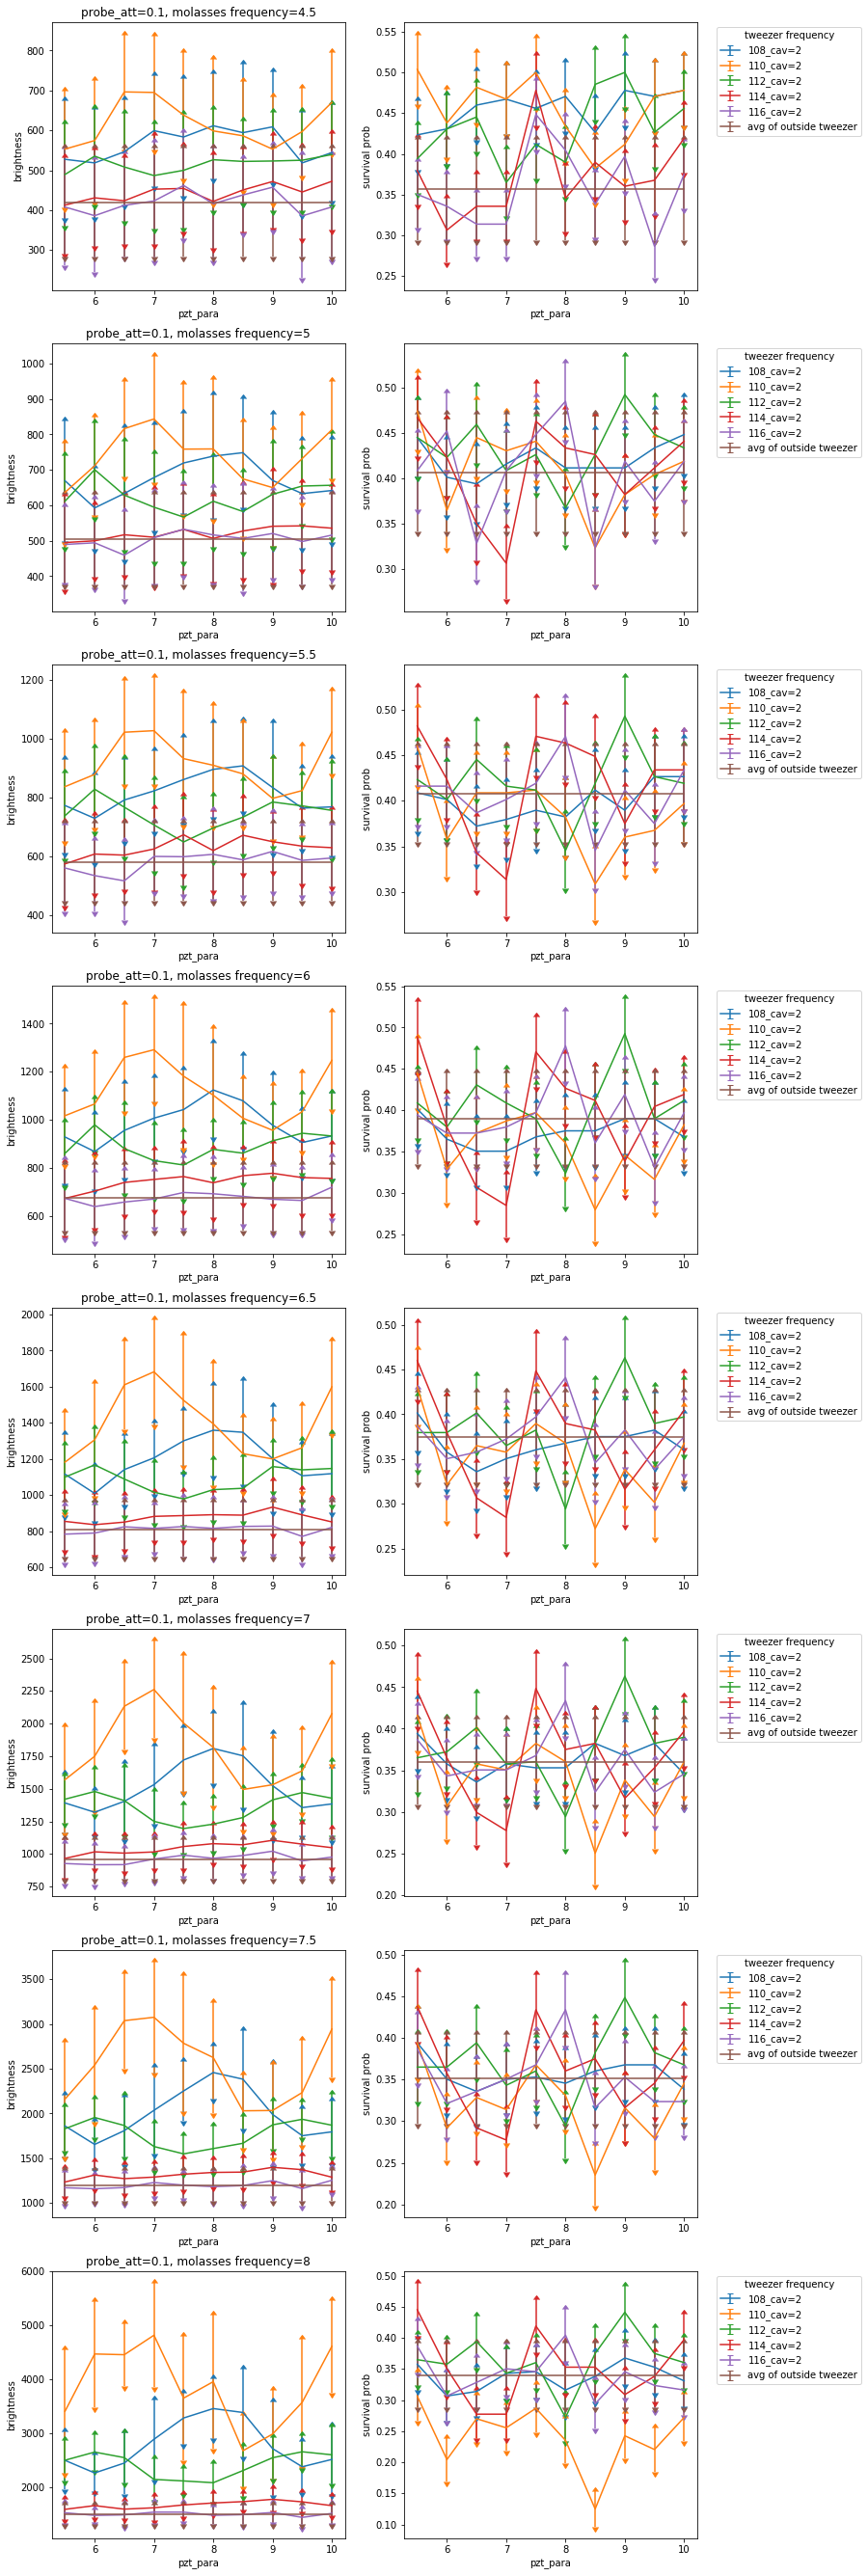

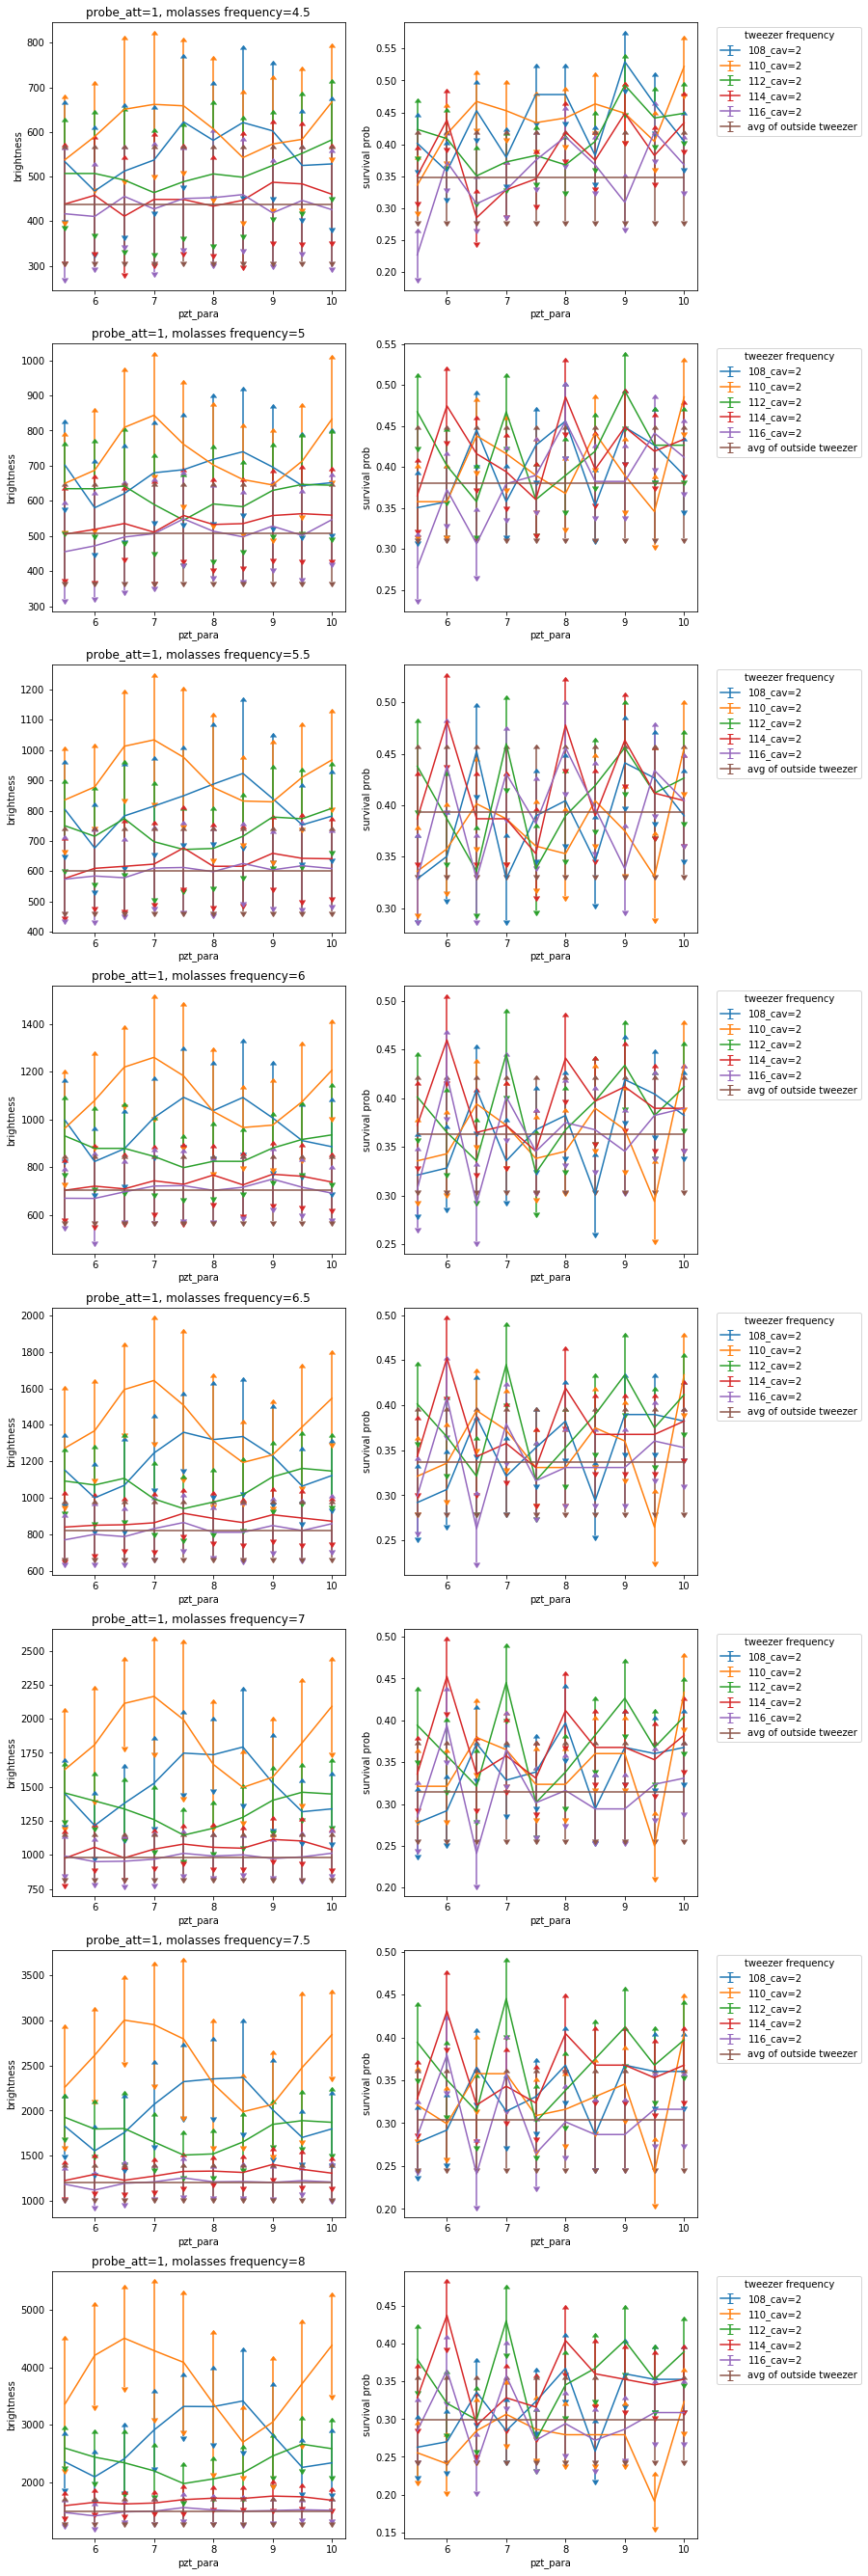

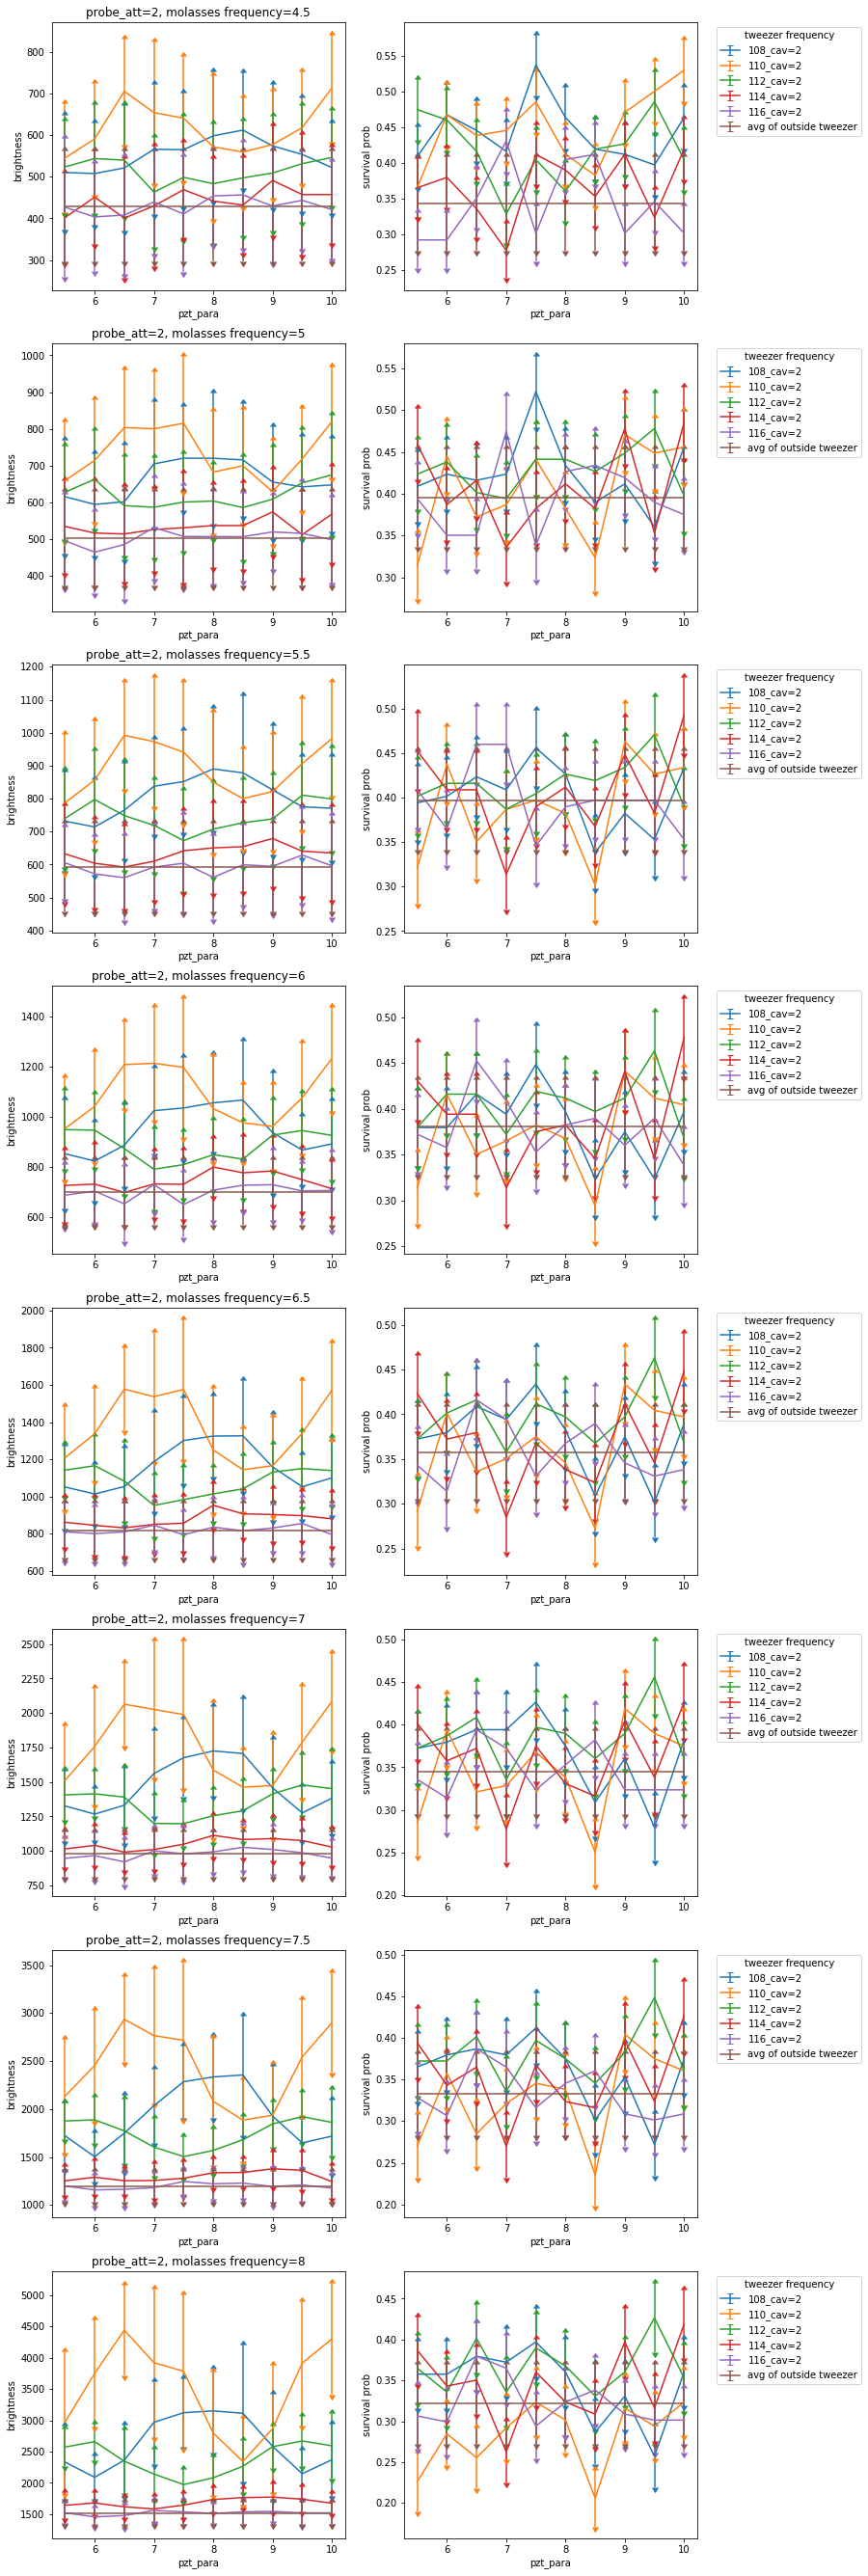

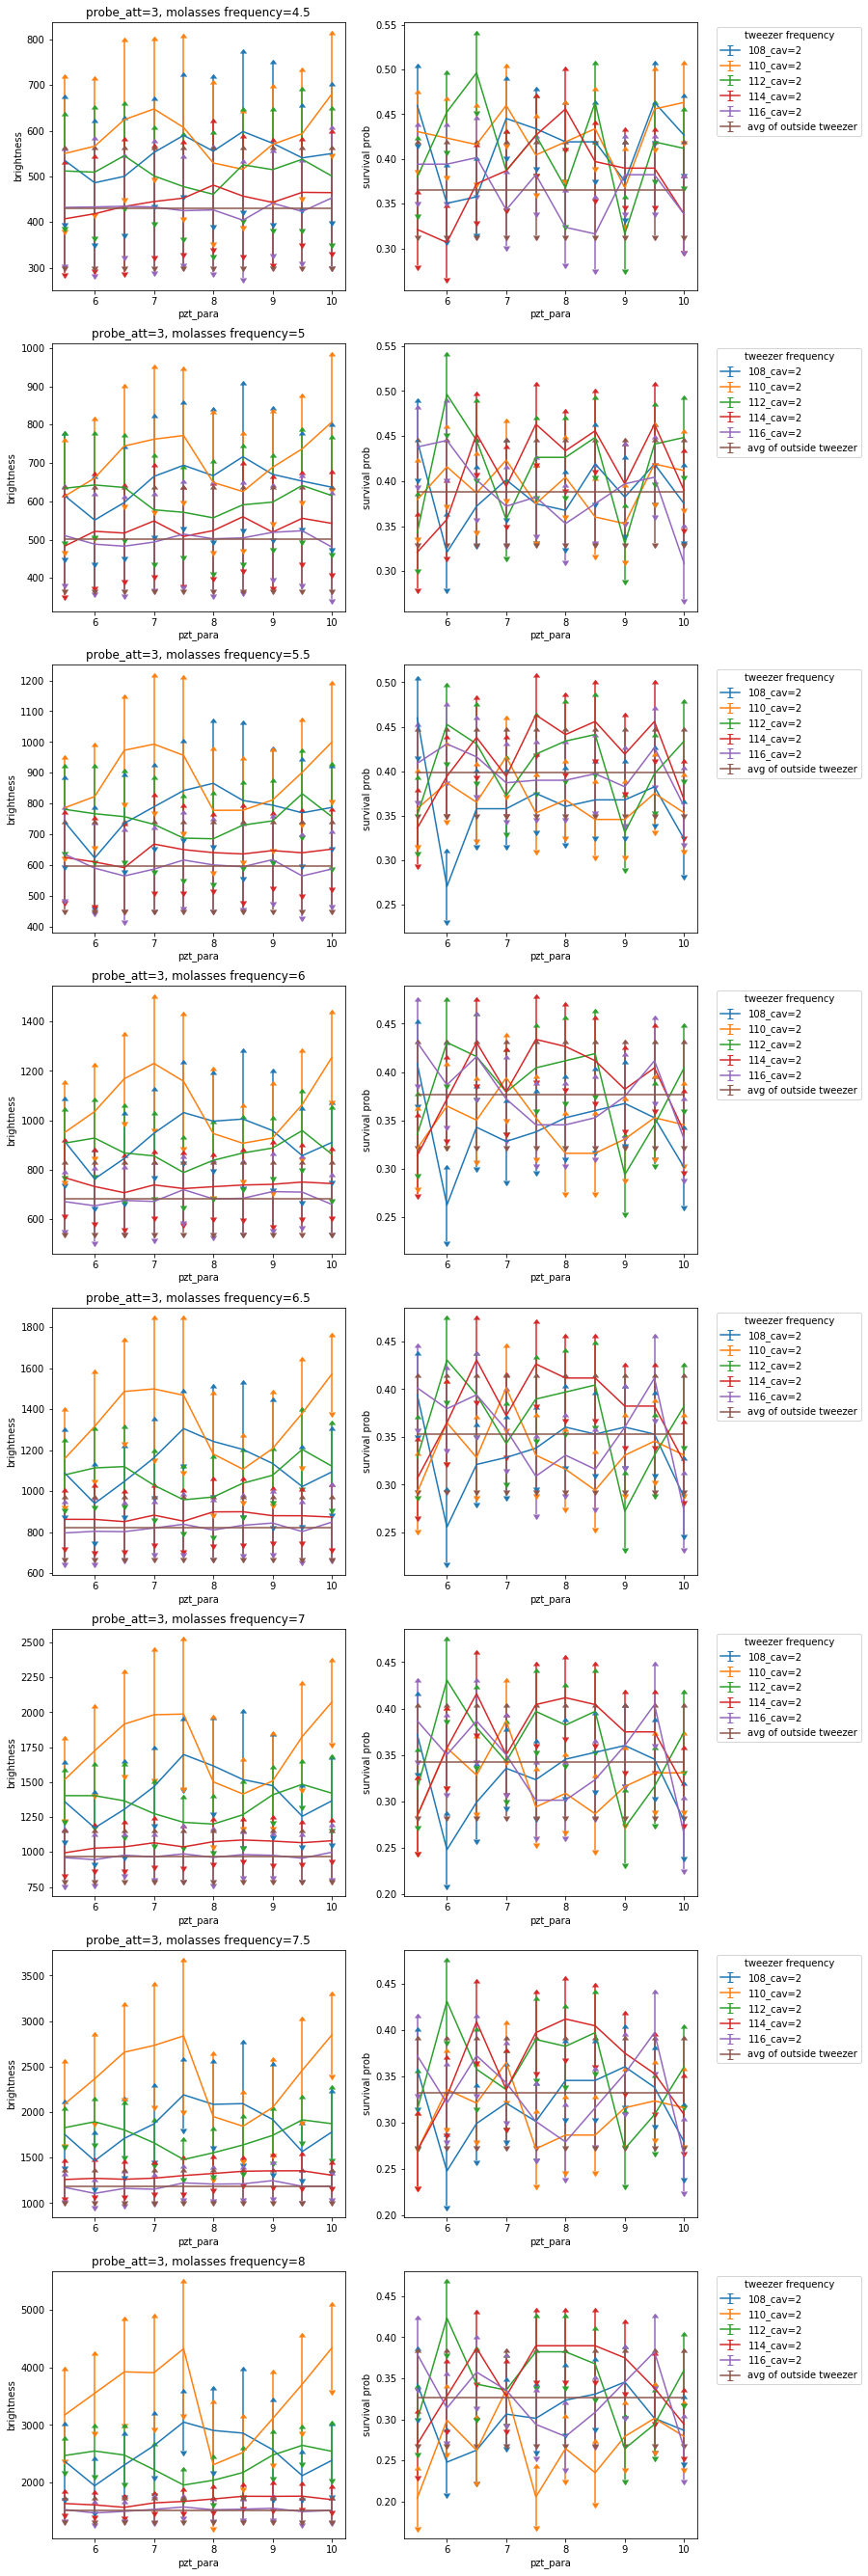

In [14]:
for probe_att_counter in range(len(probe_att_list)):
    fig, axs = plt.subplots(len(mol_freq_list), 2,  figsize=(12, len(mol_freq_list)*6))

    for mol_counter in range(len(mol_freq_list)):
        axs[mol_counter,0].set_xlabel('pzt_para')
        axs[mol_counter,0].set_ylabel('brightness')
        axs[mol_counter,1].set_xlabel('pzt_para')
        axs[mol_counter,1].set_ylabel('survival prob')
        axs[mol_counter,0].set_title(f'probe_att={probe_att_list[probe_att_counter]}, molasses frequency={mol_freq_list[mol_counter]}')
    #     axs[mol_counter].errorbar(np.array(tweezer_freq_list) , all_brightness[mol_counter, 0, :] , \
    #     yerr = all_brightness_sigma[mol_counter, 0, :],  uplims=True, lolims=True, label= 'sum')
        for tweezer_counter in range(len(tweezer_freq_list)):
    #         axs[mol_counter].errorbar(np.array(pzt_para_list), nocav_brightness[mol_counter, :, tweezer_counter] + 0*400 * tweezer_counter, \
    #         yerr = nocav_brightness_sigma[mol_counter, :, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_nocav')
            axs[mol_counter,0].errorbar(np.array(pzt_para_list), cav_brightness[mol_counter, probe_att_counter, :, tweezer_counter] + 0*400 * tweezer_counter, \
            yerr = cav_brightness_sigma[mol_counter, probe_att_counter, :, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
            axs[mol_counter,1].errorbar(np.array(pzt_para_list), cav_fidelity[mol_counter, probe_att_counter, :, tweezer_counter] + 0*400 * tweezer_counter, \
            yerr = cav_fidelity_sigma[mol_counter, probe_att_counter, :, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
        
        axs[mol_counter,0].errorbar(np.array(pzt_para_list), bg_brightness[mol_counter, probe_att_counter] * np.ones(len(pzt_para_list)) , \
        yerr = bg_brightness_sigma[mol_counter, probe_att_counter]* np.ones(len(pzt_para_list)),  uplims=True, lolims=True, label= f'avg of outside tweezer')
        axs[mol_counter,1].errorbar(np.array(pzt_para_list), bg_fidelity[mol_counter, probe_att_counter] * np.ones(len(pzt_para_list)) , \
        yerr = bg_fidelity_sigma[mol_counter, probe_att_counter]* np.ones(len(pzt_para_list)),  uplims=True, lolims=True, label= f'avg of outside tweezer')
        axs[mol_counter,1].legend(title='tweezer frequency', bbox_to_anchor=(1.05, 1), loc='upper left')
        axs[mol_counter,0].tick_params(axis='y')
        axs[mol_counter,1].tick_params(axis='y')

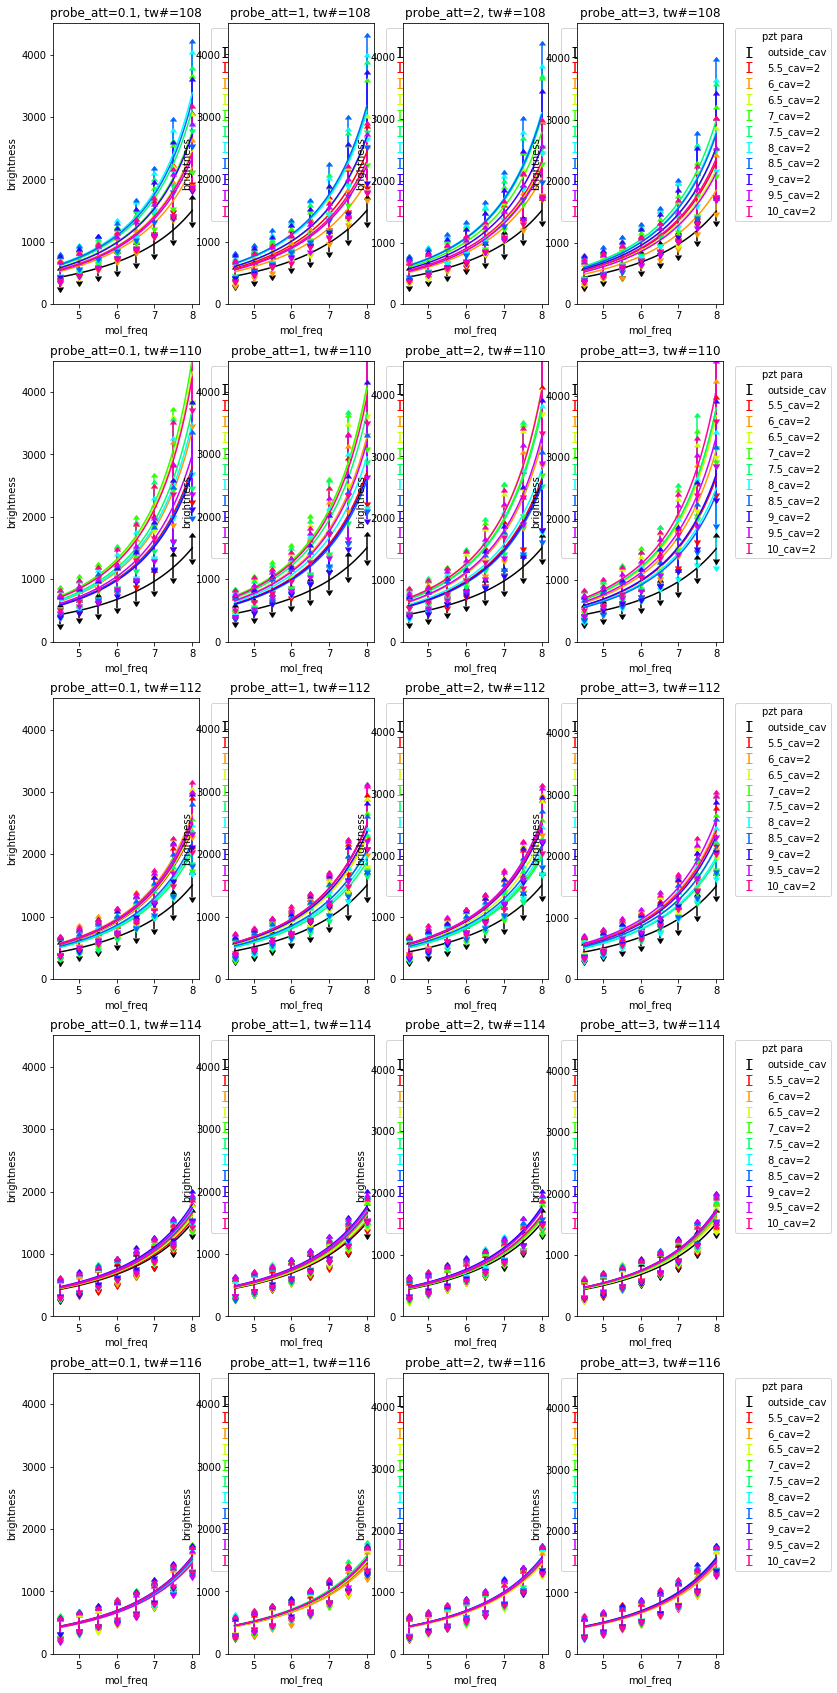

In [19]:
ac_compensation = 0.11


def func(x, a, center):
    return  a / (x-center)**2

starkshift = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list)))
sigma_starkshift = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list)))

fig, axs = plt.subplots(len(tweezer_freq_list), len(probe_att_list[:]),  figsize=(12, len(tweezer_freq_list)*6))

for probe_att, probe_att_counter in zip(probe_att_list[:], range(len(probe_att_list[:]))):

#     fig, axs = plt.subplots(len(tweezer_freq_list), 1,  figsize=(12, len(tweezer_freq_list)*9))
    for tweezer_counter in range(len(tweezer_freq_list)):
        axs[tweezer_counter,probe_att_counter].set_xlabel('mol_freq')
        axs[tweezer_counter,probe_att_counter].set_ylabel('brightness')
        axs[tweezer_counter,probe_att_counter].set_title(f'probe_att={probe_att}, tw#={tweezer_freq_list[tweezer_counter]}')
    #     axs[mol_counter].errorbar(np.array(tweezer_freq_list) , all_brightness[mol_counter, 0, :] , \
    #     yerr = all_brightness_sigma[mol_counter, 0, :],  uplims=True, lolims=True, label= 'sum')
    
    
        mask = bg_brightness[:, probe_att_counter] > 400
        popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], bg_brightness[:, probe_att_counter][mask],\
                               sigma = bg_brightness_sigma[:, probe_att_counter][mask], p0=[22000, 10.5], maxfev = 10000)
        a_nocav, center_nocav = popt
        def func2(x, center):
            return  a_nocav / (x-center)**2
        sigma_center_nocav = np.sqrt(pcov[1,1])
        sigma_a_nocav = np.sqrt(pcov[0,0])
        axs[tweezer_counter,probe_att_counter].plot(np.arange(4.5,8.1,0.1),func(np.arange(4.5,8.1,0.1), a_nocav, center_nocav), linestyle='-', c = 'black')
        axs[tweezer_counter,probe_att_counter].errorbar(np.array(mol_freq_list)[mask],  bg_brightness[:, probe_att_counter][mask],\
        yerr = bg_brightness_sigma[:, probe_att_counter][mask],  uplims=True, lolims=True, label= f'outside_cav', linestyle='', c = 'black')
        for pzt_counter in range(0, len(pzt_para_list)):
            
            color = colorsys.hsv_to_rgb(pzt_counter/len(pzt_para_list),1,1)
            
            mask = np.logical_and(np.logical_and(np.logical_and(cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter] > 300 ,\
                cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter]  < 30*max(bg_brightness[:, probe_att_counter])),\
                cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter] <2000)     ,\
                cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter] >0.1)       
#             print(np.array(mol_freq_list)[mask])
#             popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter][mask],\
#                                sigma = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask], p0=[32000, 10.5], maxfev = 10000)
            if len(np.array(mol_freq_list)[mask]) > 0:
                popt, pcov = curve_fit(func2, np.array(mol_freq_list)[mask], cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter][mask],\
                               sigma = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask], p0=[ 10.5], maxfev = 10000)
            else:
                popt = [0]
                pcov = np.zeros((1,1))
            center_cav = popt
            sigma_center_cav = np.sqrt(pcov[0,0])
            starkshift_temp = center_nocav - center_cav + ac_compensation
            sigma_starkshift_temp = np.sqrt(sigma_center_nocav**2 + sigma_center_cav**2)
            starkshift[probe_att_counter, tweezer_counter, pzt_counter] = starkshift_temp
            sigma_starkshift[probe_att_counter, tweezer_counter, pzt_counter] = sigma_starkshift_temp
#             print([starkshift_temp,sigma_starkshift_temp])
    #         print(starkshift)
            axs[tweezer_counter,probe_att_counter].errorbar(np.array(mol_freq_list)[mask], cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter][mask], \
            yerr = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask],  uplims=True, lolims=True, label= f'{pzt_para_list[pzt_counter]}_cav=2', linestyle='', color = color)
            axs[tweezer_counter,probe_att_counter].plot(np.arange(4.5,8.1,0.1),func2(np.arange(4.5,8.1,0.1),  center_cav), linestyle='-', color = color)

            axs[tweezer_counter,probe_att_counter].set_ylim([0, 3*np.amax(bg_brightness[:, probe_att_counter])])

        axs[tweezer_counter,probe_att_counter].legend(title='pzt para', bbox_to_anchor=(1.05, 1), loc='upper left')
        axs[tweezer_counter,probe_att_counter].tick_params(axis='y')

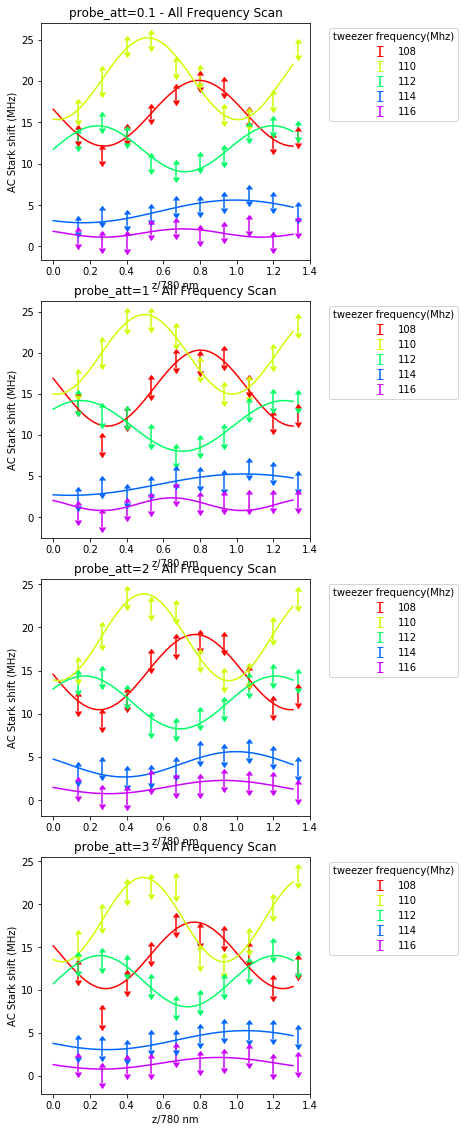

In [20]:

def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 

fig, axs = plt.subplots(len(probe_att_list), 1,  figsize=(5, 4*len(probe_att_list)))

fig.tight_layout(pad=3, w_pad=3, h_pad=2.0)
contrast_guess = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
y_mag = 13.64
x_mag = 2/7.5

for probe_att, probe_att_counter in zip(probe_att_list, range(len(probe_att_list))):
    for tweezer_counter in range(len(tweezer_freq_list)):
   
        
        popt, pcov = curve_fit(func_cos, np.array(pzt_para_list), starkshift[probe_att_counter,tweezer_counter, :],\
                               sigma = sigma_starkshift[probe_att_counter, tweezer_counter, :], p0=[1, 1, 7, 0], maxfev = 10000)
        a, b, wavelength, phi = popt
        sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
        contrast_fit[probe_att_counter, tweezer_counter] = np.abs(a/b)
        average_fit[probe_att_counter, tweezer_counter] = np.abs(b)
        wavelength_fit[probe_att_counter, tweezer_counter] = wavelength

        sigma_contrast_fit[probe_att_counter, tweezer_counter] = contrast_fit[probe_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
        sigma_average_fit[probe_att_counter, tweezer_counter] = sigma_b
        sigma_wavelength_fit[probe_att_counter, tweezer_counter] = sigma_wavelength

        xx = np.arange(5,10,0.1)
        yy = func_cos(xx,a,b,wavelength,phi)
        color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)
        axs[probe_att_counter ].plot(x_mag * (xx-5),y_mag * yy,'-', color = color)
        axs[probe_att_counter ].set_xlabel('z/780 nm')
        axs[probe_att_counter ].set_ylabel('AC Stark shift (MHz)')
        axs[probe_att_counter ].set_title(f'probe_att={probe_att} - All Frequency Scan')
    #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
        axs[probe_att_counter ].errorbar(x_mag * (np.array(pzt_para_list)-5), y_mag * starkshift[probe_att_counter, tweezer_counter, :],\
                                             yerr = y_mag * sigma_starkshift[probe_att_counter,  tweezer_counter,:], uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}', ls='', color = color)
        axs[probe_att_counter ].legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
        contrast_guess[probe_att_counter, tweezer_counter] = (max(starkshift[probe_att_counter, tweezer_counter, :])-min(starkshift[probe_att_counter, tweezer_counter, :]))/\
         (max(starkshift[probe_att_counter, tweezer_counter, :])+min(starkshift[probe_att_counter, tweezer_counter, :]))
        plt.savefig('Scans0.png',dpi=1000)


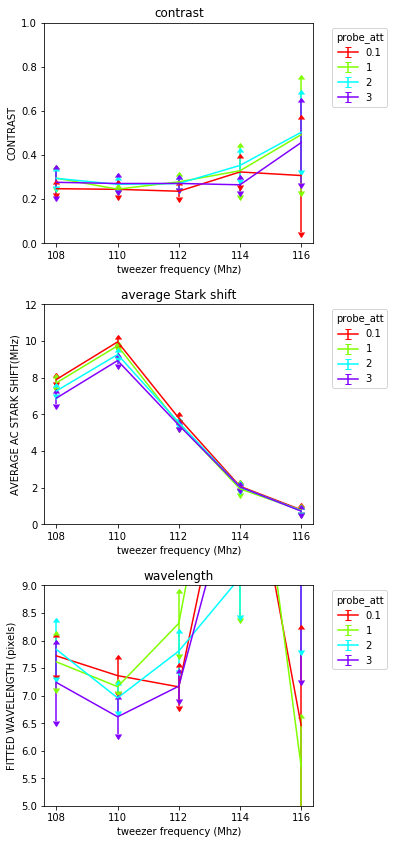

In [21]:

fig, ax = plt.subplots(3,1,  figsize=(5,12))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for probe_att, probe_att_counter in zip(probe_att_list, range(len(probe_att_list))):
    color = colorsys.hsv_to_rgb(probe_att_counter/len(probe_att_list),1,1)
    ax[0].set_xlabel('tweezer frequency (Mhz)')
    ax[0].set_ylabel('CONTRAST')
    ax[0].set_ylim([0,1])
    ax[0].set_title(f'contrast')
    # ax[0].plot(tweezer_freq_list[0:10], contrast_guess[0:10],label = 'contrast_guess')
    ax[0].errorbar(tweezer_freq_list[0:5], contrast_fit[probe_att_counter, 0:5], \
                                         yerr = sigma_contrast_fit[probe_att_counter, 0:5], \
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[0].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')

    ax[1].set_xlabel('tweezer frequency (Mhz)')
    ax[1].set_ylabel('AVERAGE AC STARK SHIFT(MHz)')
    ax[1].set_ylim([0,12])
    ax[1].set_title(f'average Stark shift')
    ax[1].errorbar(tweezer_freq_list[0:5], average_fit[probe_att_counter, 0:5]*6.69,\
                                         yerr = sigma_average_fit[probe_att_counter, 0:5]*6.69,\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[1].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')


    ax[2].set_xlabel('tweezer frequency (Mhz)')
    ax[2].set_ylabel('FITTED WAVELENGTH (pixels)')
    ax[2].set_ylim([5,9])
    ax[2].set_title(f'wavelength')
    ax[2].errorbar(tweezer_freq_list[0:5], wavelength_fit[probe_att_counter, 0:5],\
                                         yerr = sigma_wavelength_fit[probe_att_counter, 0:5],\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
ax[0].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[2].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('Tweezers0.png',dpi=1000)

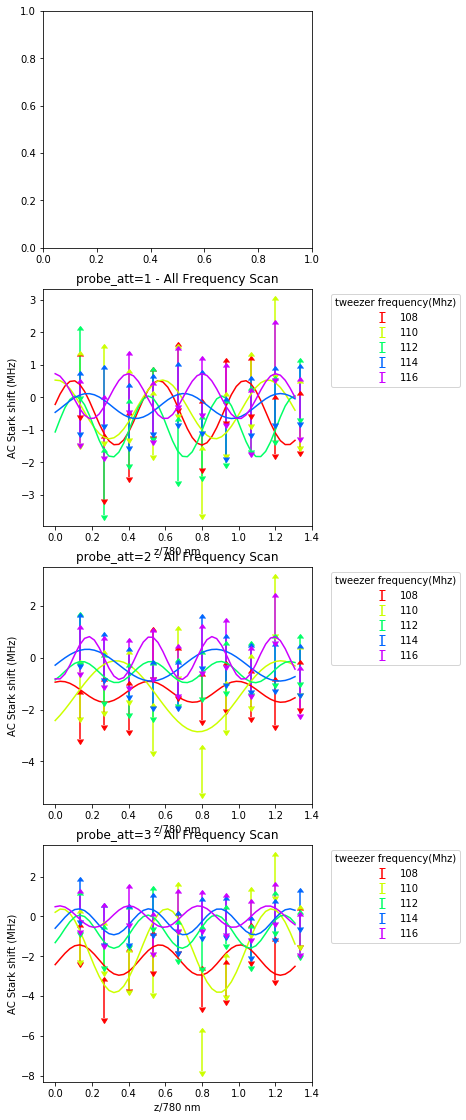

In [22]:

def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 

fig, axs = plt.subplots(len(probe_att_list), 1,  figsize=(5, 4*len(probe_att_list)))

fig.tight_layout(pad=3, w_pad=3, h_pad=2.0)
contrast_guess = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
y_mag = 13.64
x_mag = 2/7.5

for probe_att, probe_att_counter in zip(probe_att_list[1:], range(1,len(probe_att_list))):
    for tweezer_counter in range(len(tweezer_freq_list)):
   
        
        popt, pcov = curve_fit(func_cos, np.array(pzt_para_list), starkshift[probe_att_counter,tweezer_counter, :] - starkshift[0,tweezer_counter, :],\
                               sigma = sigma_starkshift[probe_att_counter, tweezer_counter, :], p0=[1, 1, 3.5, 0], maxfev = 10000)
        a, b, wavelength, phi = popt
        sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
        contrast_fit[probe_att_counter, tweezer_counter] = np.abs(a/b)
        average_fit[probe_att_counter, tweezer_counter] = np.abs(b)
        wavelength_fit[probe_att_counter, tweezer_counter] = wavelength

        sigma_contrast_fit[probe_att_counter, tweezer_counter] = contrast_fit[probe_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
        sigma_average_fit[probe_att_counter, tweezer_counter] = sigma_b
        sigma_wavelength_fit[probe_att_counter, tweezer_counter] = sigma_wavelength

        xx = np.arange(5,10,0.1)
        yy = func_cos(xx,a,b,wavelength,phi)
        color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)
        axs[probe_att_counter ].plot(x_mag * (xx-5),y_mag * yy,'-', color = color)
        axs[probe_att_counter ].set_xlabel('z/780 nm')
        axs[probe_att_counter ].set_ylabel('AC Stark shift (MHz)')
        axs[probe_att_counter ].set_title(f'probe_att={probe_att} - All Frequency Scan')
    #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
        axs[probe_att_counter ].errorbar(x_mag * (np.array(pzt_para_list)-5), y_mag * (starkshift[probe_att_counter, tweezer_counter, :] - starkshift[0,tweezer_counter, :]),\
                                             yerr = y_mag * sigma_starkshift[probe_att_counter,  tweezer_counter,:], uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}', ls='', color = color)
        axs[probe_att_counter ].legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
        contrast_guess[probe_att_counter, tweezer_counter] = (max(starkshift[probe_att_counter, tweezer_counter, :])-min(starkshift[probe_att_counter, tweezer_counter, :]))/\
         (max(starkshift[probe_att_counter, tweezer_counter, :])+min(starkshift[probe_att_counter, tweezer_counter, :]))
        plt.savefig('Probe_Scans0.png',dpi=1000)


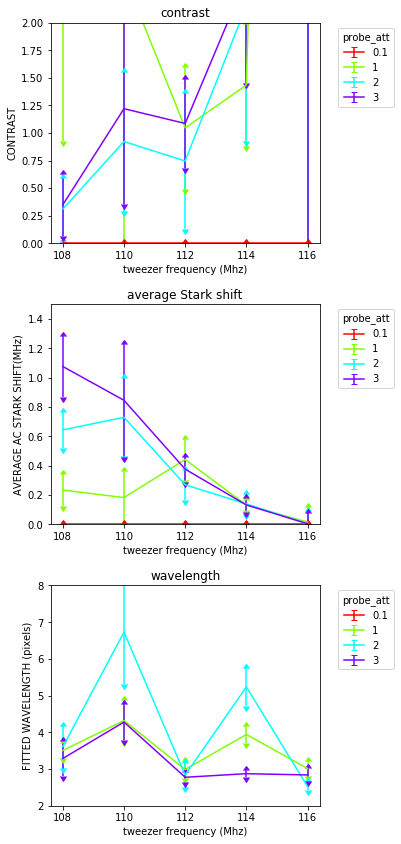

In [23]:

fig, ax = plt.subplots(3,1,  figsize=(5,12))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for probe_att, probe_att_counter in zip(probe_att_list, range(len(probe_att_list))):
    color = colorsys.hsv_to_rgb(probe_att_counter/len(probe_att_list),1,1)
    ax[0].set_xlabel('tweezer frequency (Mhz)')
    ax[0].set_ylabel('CONTRAST')
    ax[0].set_ylim([0,2])
    ax[0].set_title(f'contrast')
    # ax[0].plot(tweezer_freq_list[0:10], contrast_guess[0:10],label = 'contrast_guess')
    ax[0].errorbar(tweezer_freq_list[0:5], contrast_fit[probe_att_counter, 0:5], \
                                         yerr = sigma_contrast_fit[probe_att_counter, 0:5], \
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[0].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')

    ax[1].set_xlabel('tweezer frequency (Mhz)')
    ax[1].set_ylabel('AVERAGE AC STARK SHIFT(MHz)')
    ax[1].set_ylim([0,1.5])
    ax[1].set_title(f'average Stark shift')
    ax[1].errorbar(tweezer_freq_list[0:5], average_fit[probe_att_counter, 0:5]*6.69,\
                                         yerr = sigma_average_fit[probe_att_counter, 0:5]*6.69,\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[1].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')


    ax[2].set_xlabel('tweezer frequency (Mhz)')
    ax[2].set_ylabel('FITTED WAVELENGTH (pixels)')
    ax[2].set_ylim([2,8])
    ax[2].set_title(f'wavelength')
    ax[2].errorbar(tweezer_freq_list[0:5], wavelength_fit[probe_att_counter, 0:5],\
                                         yerr = sigma_wavelength_fit[probe_att_counter, 0:5],\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
ax[0].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[2].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('Probe_Tweezers0.png',dpi=1000)

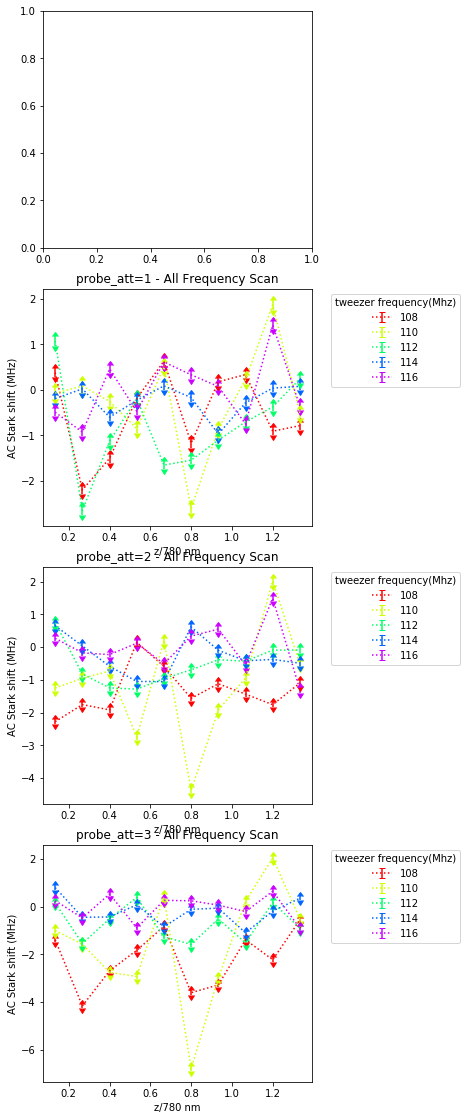

In [24]:

def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 

fig, axs = plt.subplots(len(probe_att_list), 1,  figsize=(5, 4*len(probe_att_list)))

fig.tight_layout(pad=3, w_pad=3, h_pad=2.0)
contrast_guess = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
y_mag = 13.64
x_mag = 2/7.5

for probe_att, probe_att_counter in zip(probe_att_list[1:], range(1,len(probe_att_list))):
    for tweezer_counter in range(len(tweezer_freq_list)):
   
        
        popt, pcov = curve_fit(func_cos, np.array(pzt_para_list), starkshift[probe_att_counter,tweezer_counter, :] - starkshift[0,tweezer_counter, :],\
                               sigma = sigma_starkshift[probe_att_counter, tweezer_counter, :], p0=[1, 1, 3.5, 0], maxfev = 10000)
        a, b, wavelength, phi = popt
        sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
        contrast_fit[probe_att_counter, tweezer_counter] = np.abs(a/b)
        average_fit[probe_att_counter, tweezer_counter] = np.abs(b)
        wavelength_fit[probe_att_counter, tweezer_counter] = wavelength

        sigma_contrast_fit[probe_att_counter, tweezer_counter] = contrast_fit[probe_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
        sigma_average_fit[probe_att_counter, tweezer_counter] = sigma_b
        sigma_wavelength_fit[probe_att_counter, tweezer_counter] = sigma_wavelength

        xx = np.arange(5,10,0.1)
        yy = func_cos(xx,a,b,wavelength,phi)
        color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)
#         axs[probe_att_counter ].plot(x_mag * (xx-5),y_mag * yy,'-', color = color)
        axs[probe_att_counter ].set_xlabel('z/780 nm')
        axs[probe_att_counter ].set_ylabel('AC Stark shift (MHz)')
        axs[probe_att_counter ].set_title(f'probe_att={probe_att} - All Frequency Scan')
    #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
        axs[probe_att_counter ].errorbar(x_mag * (np.array(pzt_para_list)-5), y_mag * (starkshift[probe_att_counter, tweezer_counter, :] - starkshift[0,tweezer_counter, :]),\
                                             yerr =0.1* y_mag * sigma_starkshift[probe_att_counter,  tweezer_counter,:], uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}', ls=':', color = color)
        axs[probe_att_counter ].legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
        contrast_guess[probe_att_counter, tweezer_counter] = (max(starkshift[probe_att_counter, tweezer_counter, :])-min(starkshift[probe_att_counter, tweezer_counter, :]))/\
         (max(starkshift[probe_att_counter, tweezer_counter, :])+min(starkshift[probe_att_counter, tweezer_counter, :]))
        plt.savefig('Probe_Scans0.png',dpi=1000)